## Dataset
This study utilizes data from the https://physionet.org/content/mimic-iv-ecg/1.0/
MIMIC-IV-ECG, dataset available through PhysioNet. The dataset includes over 800,000
12-lead ECG recordings from more than 150,000 patients, each sampled at 500
Hz over a 10-second window.
The dataset includes three main components:
(1) ECG waveforms or record df recorded during emergency department
visits, inpatient stays, and outpatient visits;
(2) machine-generated measurements or measure df (e.g., RR interval,
QRS duration, QTc) extracted automatically by ECG devices and stored in
machine measurements.csv;
(3) associated diagnostic labels or outcomes df (e.g. mortality informa-
tion) are stored in records w diag icd10.csv;

# Contributors

- [@cginder](https://github.com/cginder)
- [@mondira17](https://github.com/mondira17)
- [@ounlu](https://github.com/ounlu)
- [@nikita-bedi](https://github.com/nikita-bedi)

In [ ]:
#Install Required Packages
!pip install wfdb


In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import os
from google.colab import drive
import re
import collections


In [ ]:
#Global plot settings
plt.rcParams["figure.figsize"] = [20, 10]  # width, height in inches


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #Code to download ECG Data to Google Drive --- takes forever to run, so commented out
# !aws s3 sync --no-sign-request s3://physionet-open/mimic-iv-ecg/1.0/ \
# /content/drive/MyDrive/AC209B/RAW_DATA/ECG/

In [ ]:
#download mortality/timing data, machine ECG measurements, and record linking files
directory_path = "/content/drive/MyDrive/AC209B/RAW_DATA/MORTALITY/"  # Path to the directory

downloads = {    "/content/drive/MyDrive/AC209B/RAW_DATA/MORTALITY/records_w_diag_icd10.csv": "https://physionet.org/files/mimic-iv-ecg-ext-icd-labels/1.0.1/records_w_diag_icd10.csv",
    "/content/drive/MyDrive/AC209B/RAW_DATA/ECG/machine_measurements.csv": "https://physionet.org/files/mimic-iv-ecg/1.0/machine_measurements.csv",
    "/content/drive/MyDrive/AC209B/RAW_DATA/ECG/record_list.csv": "https://physionet.org/files/mimic-iv-ecg/1.0/record_list.csv?download"

}

for file_or_dir_path, url in downloads.items():
    if not os.path.exists(file_or_dir_path):
        if os.path.isdir(file_or_dir_path) or file_or_dir_path.endswith("/"):  # Check if it's a directory
            !wget -r -N -c -np --user cginder --ask-password "{url}"
        else:  # It's a file
            !wget -O "{file_or_dir_path}" "{url}"
        print(f"{file_or_dir_path} downloaded.")
    else:
        print(f"{file_or_dir_path} already exists.")

In [ ]:
# Read in files
outcome_df = pd.read_csv('/content/drive/MyDrive/AC209B/RAW_DATA/MORTALITY/records_w_diag_icd10.csv')
measure_df = pd.read_csv('/content/drive/MyDrive/AC209B/RAW_DATA/ECG/machine_measurements.csv')
record_df = pd.read_csv('/content/drive/MyDrive/AC209B/RAW_DATA/ECG/record_list.csv')


In [ ]:
# Convert file_name to match our directory structure on Google Drive
# strip mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/ from 'file_name'
outcome_df['file_name'] = outcome_df['file_name'].str.replace('mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/', '')

#append drive directory to file_name
outcome_df['file_name'] = '/content/drive/MyDrive/AC209B/RAW_DATA/ECG/' + outcome_df['file_name']

#Confirm
print(outcome_df['file_name'][0])

/content/drive/MyDrive/AC209B/RAW_DATA/ECG/files/p1000/p10000032/s40689238/40689238


## Data Description

We have three separate meta-data files relevant to our project:

1. outcome_df: this file contains the file_path of the ECG waveforms, information on the study and subject ID, demographic information (age, gender), the time (date-shifted for anonymity), information about the setting where the ECG was obtained, diagnostic information related to the hospital or ED stay (if obtained during one of these encounter types), and date of death, if applicable. 30-day mortality from date of obtaining an ECG is our proposed primary outcome, and so we will plan to use this last column as our training label.

2. measure_df: this file contains machine-generated information related to each ECG file, including the interpretations (stored under 'report_#' columns), settings under which the ECG was obtained (bandwidth and filtering) and standard ECG interval measurements (rr_interval, p_onset, p_end, qrs_onset, qrs_end, t_end, p_axis, qrs_axis). We will plan to use the report_# columns and the intervals for supervised training to train a model how to 'interpret' an ECG.

3. record_df: this file links study_id to each ecg file location

In [ ]:
display(outcome_df.head())
display(outcome_df.info())

In [ ]:
display(measure_df.head())
display(measure_df.info())

In [ ]:
display(record_df.head())



The overall size of this database is 90GB (33GB compressed), representing 800,000 electrocardiograms from 160,000 patients. We have loaded this into a shared Google Drive Folder as well as a GCP Bucket. To facilitate use of data of this size, we plan to focus on a smaller subset (those with ECGs obtained in an acute setting - either in the Emergency Department or Inpatient Hospitalization). Our preprocessing steps (described below) will exclude 75% of the tracing data.

In [ ]:
#Print an example of the directory of the drive:
directory_path = "/content/drive/MyDrive/AC209B/RAW_DATA/ECG/files"

def simple_tree(path, indent=""):
    try:
        items = [i for i in os.listdir(path) if not i.startswith('.')]
        items.sort()
    except Exception as e:
        print(indent + f"[Error: {e}]")
        return

    # Show first 2 items for tree expansion
    for i, item in enumerate(items[:2]):
        print(indent + "|-- " + item)
        item_path = os.path.join(path, item)

        if os.path.isdir(item_path):
            sub_items = [j for j in os.listdir(item_path) if not j.startswith('.')]
            if sub_items:
                first_two = sub_items[:2]
                for sub_item in first_two:
                    sub_path = os.path.join(item_path, sub_item)
                    print(indent + "    |-- " + sub_item)
                    if os.path.isdir(sub_path):
                        simple_tree(sub_path, indent + "        ")

# Usage
directory_path = "/content/drive/MyDrive/AC209B/RAW_DATA/ECG/files"
simple_tree(directory_path)

Each ECG tracing is held in the terminal directory starting with an 's', with files split up with .dat (contains the tracing data) and .hea (contains metadata about the tracing. We will only need to keep the .dat information, which will cut down on our file size once we perform pre-processing.

We will then examine the file structure of each ECG file. ECG waveforms in the MIMIC database are obtained as 12 channels with 5000 measurements (obtained at 500 hz over 10 seconds). This can be displayed as a numpy array, and visualized using the WFDB library as shown below.

In [ ]:
%cd /content/drive/MyDrive/AC209B/RAW_DATA/ECG/

# Print an example ECG
record_path = record_df['path'][0]

# Read the record
record = wfdb.rdrecord(record_path)

# Plot the numpy array shape + head
print('Array shape: ', record.p_signal.shape)
print('\nExample of tracing data:\n',record.p_signal[:5])

# Plot the ECG
print('\nExample ECG tracing:\n')
wfdb.plot_wfdb(record=record, title='ECG Signal')


### Data Scaling
These data are already scaled on the tracing level by the ECG machine, and so we do not anticipate needing to rescale the data prior to normalize any features when using the raw tracing data.

### Missing Data
We know from our experience in AC215, that there are ECG tracings with 'missing' data -- this typically indicates an ECG recorded in error, and shows up as flat lines. This is typically automatically flagged by the machine interpretation, but we plan to build in a process to confirm quality that the machine interpretation does not identify (by looking for the number of channels with a static line/standard deviation below a certain threshold).

Array shape:  (5000, 12)

Example of tracing data:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Example ECG tracing with Missing Data:



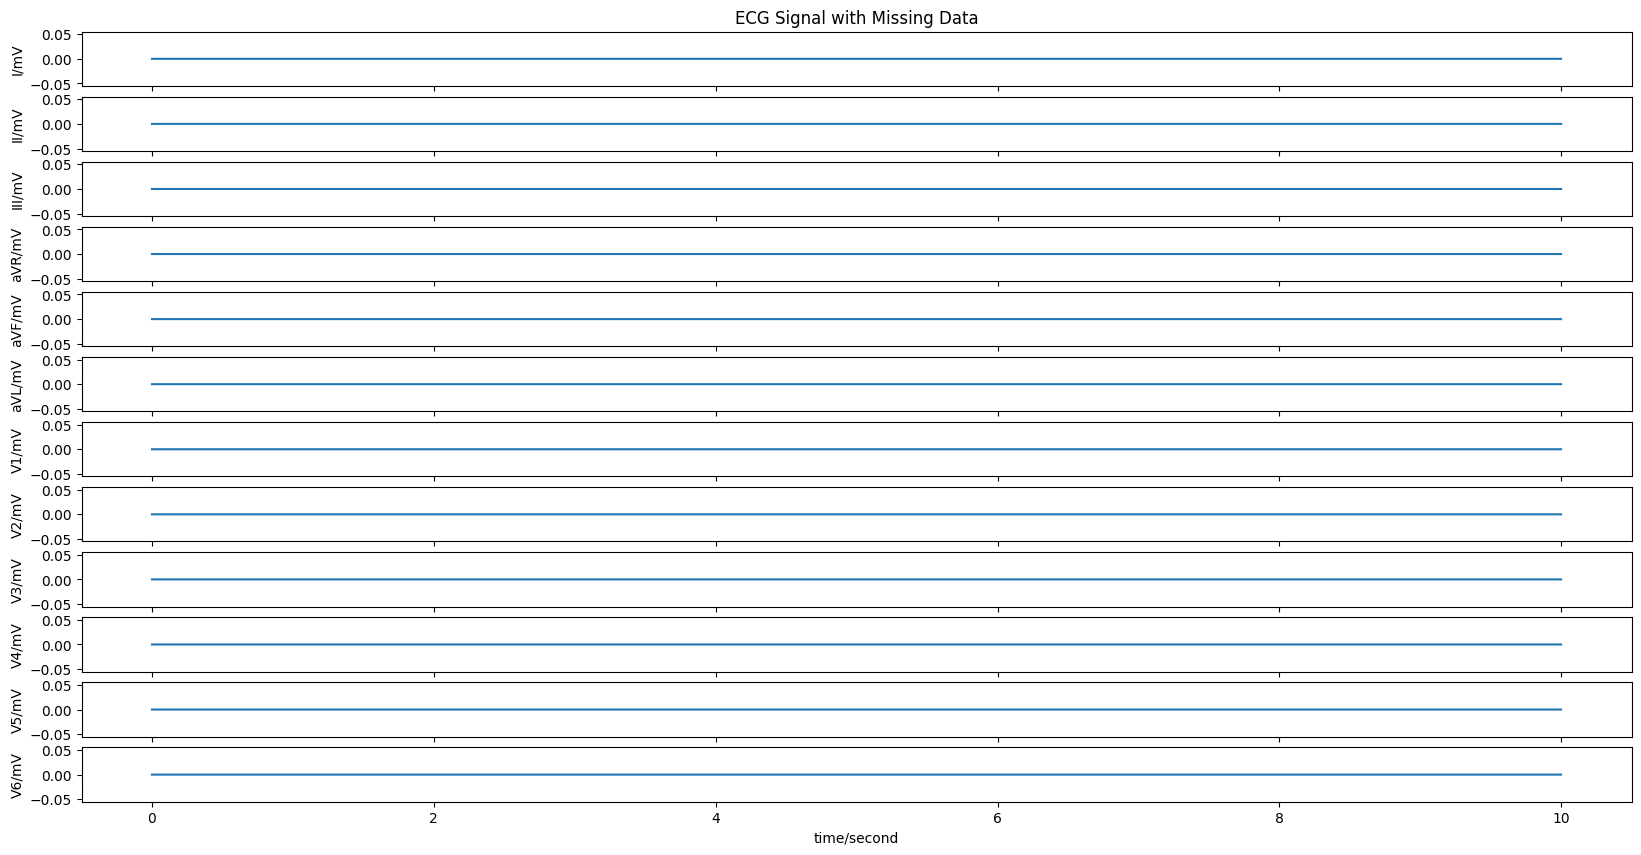

In [ ]:
#Get example tracing with missing data:
missing_data_example = measure_df[measure_df['report_0'] == 'All 12 leads are missing']['study_id'].iloc[0]

#Get file path
missing_data_path = record_df[record_df['study_id'] == missing_data_example]['path'].iloc[0]

# Read the record
missing_data_record = wfdb.rdrecord(missing_data_path)

# Print array and signal tracing
print('Array shape: ', missing_data_record.p_signal.shape)
print('\nExample of tracing data:\n',missing_data_record.p_signal[:5])

print('\nExample ECG tracing with Missing Data:\n')
wfdb.plot_wfdb(record=missing_data_record, title='ECG Signal with Missing Data')

As discussed above, we are interested in predicting mortality using ECGs (provisionally 30 days within an ECG being recorded, although may expand this to alternative time frames, or limit it to a specific patient cohort, such as those admitted to the hospital). Fortunately(!), mortality is a minority outcome in our dataset, and so we will plan for 2 approaches: 1)Upsample ECG examples that precede our outcome of interest, or 2)Downsample alive cases to arrive at a balanced dataset.

In [ ]:
print(outcome_df.columns)

Index(['file_name', 'study_id', 'subject_id', 'ecg_time', 'ed_stay_id',
       'ed_hadm_id', 'hosp_hadm_id', 'ed_diag_ed', 'ed_diag_hosp',
       'hosp_diag_hosp', 'all_diag_hosp', 'all_diag_all', 'gender', 'age',
       'anchor_year', 'anchor_age', 'dod', 'ecg_no_within_stay',
       'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'ecg_taken_in_ed_or_hosp',
       'fold', 'strat_fold'],
      dtype='object')


In [ ]:
# Convert 'ecg_time' and 'dod' columns to datetime objects
outcome_df['ecg_time'] = pd.to_datetime(outcome_df['ecg_time'])
outcome_df['dod'] = pd.to_datetime(outcome_df['dod'])

# Get number of cases with death at 30 days, 90 days, 180 days, and 365 days after an ECG obtained
outcome_df['death_30'] =  (outcome_df['dod'] <= outcome_df['ecg_time'] + pd.Timedelta(days=30))
outcome_df['death_90'] =  (outcome_df['dod'] <= outcome_df['ecg_time'] + pd.Timedelta(days=90))
outcome_df['death_180'] =  (outcome_df['dod'] <= outcome_df['ecg_time'] + pd.Timedelta(days=180))
outcome_df['death_365'] =  (outcome_df['dod'] <= outcome_df['ecg_time'] + pd.Timedelta(days=365))

# Show frequency as a percentage of each outcome
total_rows = len(outcome_df)

outcome_freq = outcome_df[['death_30', 'death_90', 'death_180', 'death_365']].sum() / total_rows

outcome_summary = pd.DataFrame({'Count': outcome_df[['death_30', 'death_90', 'death_180', 'death_365']].sum(),
                                 'Frequency': outcome_freq})
print('Frequency of each outcome:\n\n', outcome_summary)

Frequency of each outcome:

             Count  Frequency
death_30    36808   0.046008
death_90    61861   0.077323
death_180   83637   0.104542
death_365  113633   0.142035


In [ ]:
#get all categorical and numerical columns from outcome_df and num_vars
obj_cols = outcome_df.select_dtypes(include=['object']).columns.tolist()
num_vars = outcome_df.select_dtypes(exclude=['object']).columns.tolist()

#counts of obj_cols in outcome_df
obj_col_counts = outcome_df[obj_cols].nunique()
print(obj_col_counts)
#get missing data
display(f'Missing data categorical', outcome_df[obj_cols].isnull().sum())

#describe num_vars in outcome_df
display(outcome_df[num_vars].describe())
#get missing data
display(f'missing data numeric:',outcome_df[num_vars].isnull().sum())


In [ ]:
#get all categorical and numerical columns from measure_df
obj_cols = measure_df.select_dtypes(include=['object']).columns.tolist()
num_vars = measure_df.select_dtypes(exclude=['object']).columns.tolist()

#counts of obj_cols in measure_df
obj_col_counts = measure_df[obj_cols].nunique()
print(obj_col_counts)

#get missing data
display(f'Missing data categorical', measure_df[obj_cols].isnull().sum())

#describe num_vars in measure_df
display(measure_df[num_vars].describe())
#get missing data
display(f'missing data numeric:',measure_df[num_vars].isnull().sum())

ecg_time     771785
report_0       1570
report_1       2254
report_2       1631
report_3       1225
report_4       1011
report_5        760
report_6        519
report_7        335
report_8        193
report_9        108
report_10        76
report_11        47
report_12        30
report_13        18
report_14        10
report_15         4
report_16         2
report_17         1
bandwidth         3
filtering         4
dtype: int64


'Missing data categorical'

,0
ecg_time,0
report_0,1
report_1,198927
report_2,274127
report_3,406484
report_4,572485
report_5,677823
report_6,743910
report_7,777665
report_8,792774


,subject_id,study_id,cart_id,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
count,8.000350e+05,8.000350e+05,8.000350e+05,800035.000000,800035.000000,800035.000000,800035.000000,800035.000000,800035.000000,800035.000000,800035.000000,800035.000000
mean,1.500319e+07,4.499991e+07,6.579536e+06,865.603747,4702.878567,8745.082121,283.422989,391.658715,688.646508,4957.353425,107.372884,192.549746
std,2.877970e+06,2.883662e+06,2.625489e+05,1218.518102,10805.074972,13517.381192,1124.222542,1240.629232,1209.022742,11131.366005,1661.570996,2162.163457
min,1.000003e+07,4.000002e+07,6.037973e+06,0.000000,0.000000,0.000000,0.000000,0.000000,235.000000,-31248.000000,-180.000000,-32768.000000
25%,1.250369e+07,4.250407e+07,6.376932e+06,681.000000,40.000000,144.000000,186.000000,276.000000,566.000000,37.000000,-15.000000,16.000000
50%,1.500041e+07,4.499739e+07,6.632385e+06,810.000000,40.000000,158.000000,200.000000,302.000000,610.000000,56.000000,13.000000,42.000000
75%,1.749698e+07,4.749754e+07,6.762207e+06,937.000000,326.000000,29999.000000,230.000000,346.000000,668.000000,73.000000,45.000000,68.000000
max,1.999999e+07,4.999999e+07,6.998078e+06,65535.000000,29999.000000,61440.000000,29999.000000,65534.000000,29999.000000,32767.000000,32767.000000,32767.000000


'missing data numeric:'

,0
subject_id,0
study_id,0
cart_id,0
rr_interval,0
p_onset,0
p_end,0
qrs_onset,0
qrs_end,0
t_end,0
p_axis,0


The descriptive statistics provide a high-level overview of the available patient outcomes metadata. Notably, the dataset spans over 800,000 ECGs across 160,000+ patients. While demographic features such as age and gender are relatively complete, hospital mortality and death timestamps are sparse, and only a subset of ECGs are tied to admission or discharge events. Given the high rate of missing or ambiguous outcome data — and the fact that mortality may be influenced by non-cardiac factors — we decided not to use outcome-based supervised modeling in this project. Instead, we focus on ECG signal features and diagnostic reports to guide model design.

Number of unique subjects: 161352
Number of unique study_ids: 800035

Descriptive Stats of Number of ECGs per Subject:

count    161352.000000
mean          4.958321
std           8.075239
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         260.000000
Name: study_id, dtype: float64


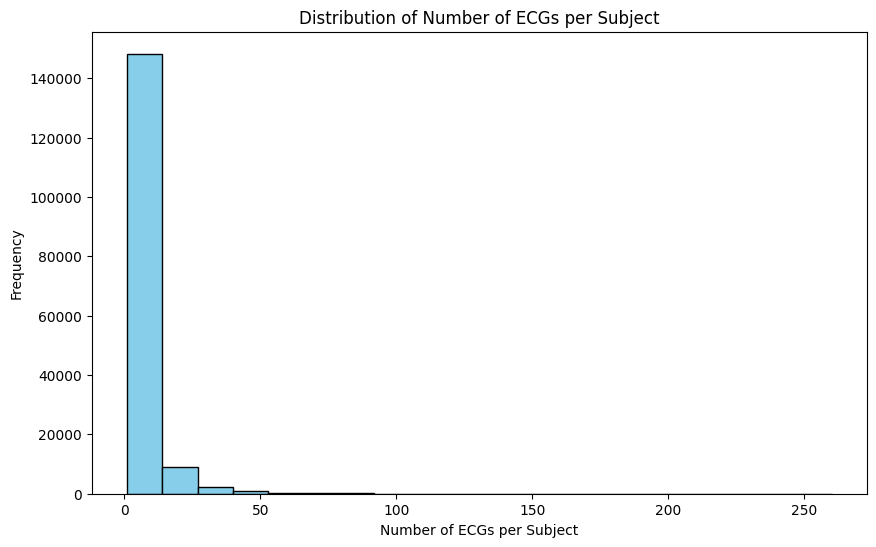

Maximum number of ECGs per subject: 260
Number of subjects with more than 10 ECGs: 18258


In [ ]:
#Look at distribution of number of ECGs per Subject

# Count the number of unique subjects
num_subjects = record_df['subject_id'].nunique()
print('Number of unique subjects:', num_subjects)

# Count the number of unique study_ids
num_study_ids = record_df['study_id'].nunique()
print('Number of unique study_ids:', num_study_ids)

# Count the number of unique study_ids per subject
num_study_ids_per_subject = record_df.groupby('subject_id')['study_id'].nunique()

#Get basic descriptive stats
print('\nDescriptive Stats of Number of ECGs per Subject:\n')
print(num_study_ids_per_subject.describe())

#Visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(num_study_ids_per_subject, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of ECGs per Subject')
plt.ylabel('Frequency')
plt.title('Distribution of Number of ECGs per Subject')
plt.show()

#Look at outliers of number of ECGs per Subject
max_study_ids_per_subject = num_study_ids_per_subject.max()
print('Maximum number of ECGs per subject:', max_study_ids_per_subject)

#Number of subjects with more than 10 ECGs
num_subjects_with_10_ecgs = num_study_ids_per_subject[num_study_ids_per_subject > 10].count()
print('Number of subjects with more than 10 ECGs:', num_subjects_with_10_ecgs)

The dataset includes 161,352 unique subjects and a total of 800,035 ECG study records, indicating an average of approximately 5 ECGs per subject.

A histogram of ECG count per subject (shown above) shows a highly right-skewed distribution, where most subjects have only a few ECGs. The majority (50%) of patients have two or fewer ECGs, and 75% have five or fewer. However, a long tail exists: one subject has as many as 260 ECGs, and 18,258 subjects (11%) have more than ten ECGs.

This imbalance is important to consider in downstream modeling. If not handled properly, the model could become biased toward subjects with more ECGs, potentially leading to overfitting and poor generalizability. To mitigate this, we plan to have subject-level train/test splits.

## Data Pre-processing

#### ECG Tracing and automatic report labels

We also know from our experience in AC215, that most clinically obtained ECGs are printed out in a different format that does not display the entire waveform data. An example is pasted below, which can be considered as cropping and rearranging of the waveform data:
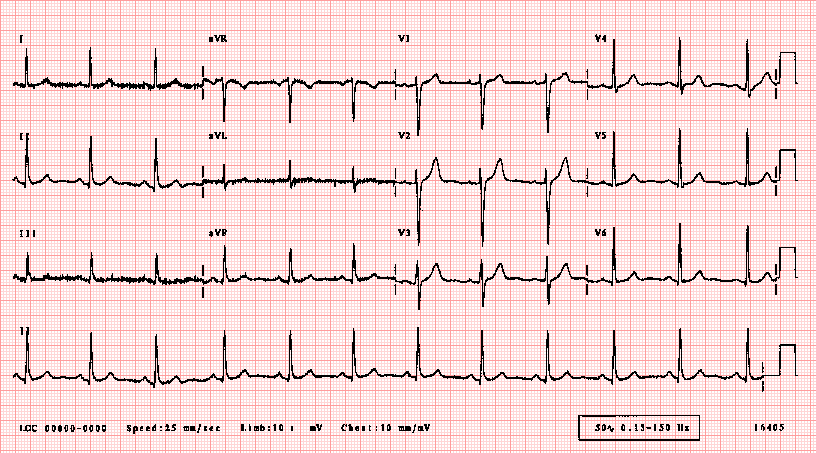

Because we hope for our model to eventually be deployed to enable ECG teaching from user-uploaded images, we plan to convert the waveform data to match this structure prior to training our models using the following code:

In [ ]:
def modify_ecg_tracing(tracing, rhythm_leads = ['V1']):
    """
    Modify the tracings to create a 6-row matrix:
    - Rows 1-3: Concatenated subsets of various leads
      - Row 1: 1/4 from lead I, 1/4 from aVR, 1/4 from V1, 1/4 from V4
      - Row 2: 1/4 from II, 1/4 from aVL, 1/4 from V2, 1/4 from V5
      - Row 3: 1/4 from III, 1/4 from aVF, 1/4 from V3, 1/4 from V6
    - Rows 4: Unmodified rhythm strips for lead II
    """
    n_time_points = 5000  # Number of time points (columns)
    segment_length = n_time_points // 4  # Length of each 1/4 segment
    modified_tracing = np.zeros((n_time_points, 3 + len(rhythm_leads)))

    # Lead indices based on the fixed order: I, II, III, AVR, AVF, AVL, V1, V2, V3, V4, V5, V6
    lead_indices = {
        'I': 0, 'II': 1, 'III': 2, 'AVR': 3, 'AVF': 4, 'AVL': 5,
        'V1': 6, 'V2': 7, 'V3': 8, 'V4': 9, 'V5': 10, 'V6': 11
    }

    # Construct Rows 1-3 (Columns are formed by segment placement)
    row_mappings = [
        ['I', 'AVR', 'V1', 'V4'],  # Row 1
        ['II', 'AVL', 'V2', 'V5'], # Row 2
        ['III', 'AVF', 'V3', 'V6'] # Row 3
    ]

    for row_idx, leads in enumerate(row_mappings):
        # Initialize column start index
        col_start = 0
        for lead in leads:
            lead_idx = lead_indices[lead]  # Get lead index from dictionary
            modified_tracing[col_start : col_start + segment_length, row_idx] = tracing[col_start : col_start + segment_length, lead_idx]
            col_start += segment_length

    # Add rhythm strip(s) for Columns 4-onward (concatenated vertically)
    col_idx = 3  # Starting column index for rhythm strips
    for lead in rhythm_leads:
        lead_idx = lead_indices[lead]  # Get lead index from dictionary
        modified_tracing[:, col_idx] = tracing[:, lead_idx]
        col_idx += 1  # Move to the next column for the next rhythm strip

    return modified_tracing

In [ ]:
modified_tracing = modify_ecg_tracing(record.p_signal)

In [ ]:
#Plot modified tracing:
def plot_modified_ecg_grid(modified_tracing, fs=500):
    """
    Plot a modified ECG with 3 composite leads and rhythm strips.
    Composite leads show vertical segment dividers and sublabels.
    """
    n_samples, n_leads = modified_tracing.shape
    time = np.arange(n_samples) / fs
    quarter = n_samples // 4

    # Subsection labels per composite lead
    subsection_labels = [
        ['I', 'aVR', 'V1', 'V4'],
        ['II', 'aVL', 'V2', 'V5'],
        ['III', 'aVF', 'V3', 'V6']
    ]

    total_rows = n_leads
    fig, axes = plt.subplots(total_rows, 1, figsize=(16, 2.2 * total_rows), sharex=True)

    for i in range(n_leads):
        ax = axes[i]
        ax.plot(time, modified_tracing[:, i], color='black', linewidth=0.8)
        ax.set_yticks([])
        ax.set_facecolor('#fffaf0')
        ax.grid(True, which='both', linestyle='--', linewidth=0.3)
        ax.set_xlim(0, time[-1])

        # Composite leads (top 3) get dividers + subsection labels
        if i < 3:
            for j in range(1, 4):
                ax.axvline(j * quarter / fs, color='red', linestyle=':', linewidth=0.8)

            ymin, ymax = ax.get_ylim()
            y_pos = ymax - 0.05 * (ymax - ymin)
            for j in range(4):
                x_pos = (j * quarter) / fs + 0.01
                ax.text(x_pos, y_pos, subsection_labels[i][j],
                        fontsize=10, fontweight='bold', ha='left', va='top')

        # Only bottom row gets x-axis labels
        if i == n_leads - 1:
            ax.set_xlabel("Time (s)")
        else:
            ax.set_xticks([])

    plt.subplots_adjust(hspace=0.2)
    fig.suptitle("Modified ECG with Composite Leads and Rhythm Strip(s)", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [ ]:
plot_modified_ecg_grid(modified_tracing, fs=500)

In [ ]:
print('Modified Tracing Shape:\n',modified_tracing.shape)

Modified Tracing Shape:
 (5000, 4)


We plan to use this modified tracing structure as our input data to train our model. We plan to explore self-supervision pre-training techniques (this should be a good application for an auto-encoder)

From a data standpoint, we have uploaded the ECG files to a Google Drive folder for exploration. We anticipate this might not have the desired latency from a data i/o standpoint, and have also uploaded the data into a GCP bucket from which we expect a much faster latency.


## Model Development

We plan to develop the following models:

1. Using a tensor of (n, 5000, 4), train a self-supervised auto-encoder to reconstruct the initial (5000, 4) tracing. The encoder can then be utilized for downstream tasks.

2. Using a tensor of (n, 5000, 4), train a supervised model to predict machine measurments (encoded report_# columns concatenated [or a separate model head] with machine measurement values). This will either be trained with random initializations or using the encoder described above, and can serve both as a useful model (to predict the report and measurements) or as a pretained model for task #3.

3. Using a tensor of (n, 5000, 4), predict mortality. We will explore using the pretrained models described above.

### Loading Data

In [ ]:
test = wfdb.rdrecord(outcome_df['file_name'][0])

In [ ]:
import multiprocessing


In [ ]:
def process_record(file_path):
    try:
        record = wfdb.rdrecord(file_path)
        modified_signal = modify_ecg_tracing(record.p_signal)
        return modified_signal, file_path
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None, file_path
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, file_path

# if __name__ == '__main__':
#     filtered_df = outcome_df[outcome_df['death_30'] == True]['file_name']
#     with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
#         results = []
#         for i, result in enumerate(pool.imap_unordered(process_record, filtered_df)):
#             results.append(result)
#             if (i + 1) % 100 == 0:
#                 print(f"Processed {i + 1} files")

#     modified_records, file_paths = zip(*results)
#     modified_records = [record for record in modified_records if record is not None]

#     # Create a dictionary to track file origins
#     record_origins = {os.path.basename(path): signal for signal, path in results if signal is not None}


In [ ]:
#Write modified_records to drive as a parquet
# modified_records.to_parquet('/content/drive/MyDrive/AC209B/PROCESSED_DATA/modified_records.parquet')

In [ ]:
pd.set_option('display.max_columns', None)

print(measure_df.columns)

Index(['subject_id', 'study_id', 'cart_id', 'ecg_time', 'report_0', 'report_1',
       'report_2', 'report_3', 'report_4', 'report_5', 'report_6', 'report_7',
       'report_8', 'report_9', 'report_10', 'report_11', 'report_12',
       'report_13', 'report_14', 'report_15', 'report_16', 'report_17',
       'bandwidth', 'filtering', 'rr_interval', 'p_onset', 'p_end',
       'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'],
      dtype='object')


In [ ]:
report_columns = [
    'report_0', 'report_1', 'report_2', 'report_3', 'report_4', 'report_5',
    'report_6', 'report_7', 'report_8', 'report_9', 'report_10', 'report_11',
    'report_12', 'report_13', 'report_14', 'report_15', 'report_16', 'report_17'
]

for col in report_columns:
    print(f"Unique values in column '{col}':")
    print(measure_df[col].unique())
    print("-" * 40)

In [ ]:
for col in report_columns:
    print(f"Value counts for column '{col}':")
    print(measure_df[col].value_counts())
    print("-" * 40)

In [ ]:
# `values.ravel()` flattens the 2‑D slice into one long 1‑D array
all_unique = pd.unique(measure_df[report_columns].values.ravel("K"))   # "K" = keep order

# Drop NaNs / blanks and turn into a clean list
all_unique = [s for s in all_unique if isinstance(s, str) and s.strip()]

print(f"{len(all_unique):,} distinct free‑text phrases found.")

3,862 distinct free‑text phrases found.


In [ ]:
value_counts = (measure_df[report_columns]
                .stack()              # melt all columns into one long Series
                .dropna()
                .astype(str).str.strip()
                .value_counts()       # count across *all* 18 columns
                .rename_axis("raw_text")
                .reset_index(name="n"))

print(value_counts.head())
print(f"{len(value_counts):,} distinct phrases in total.")

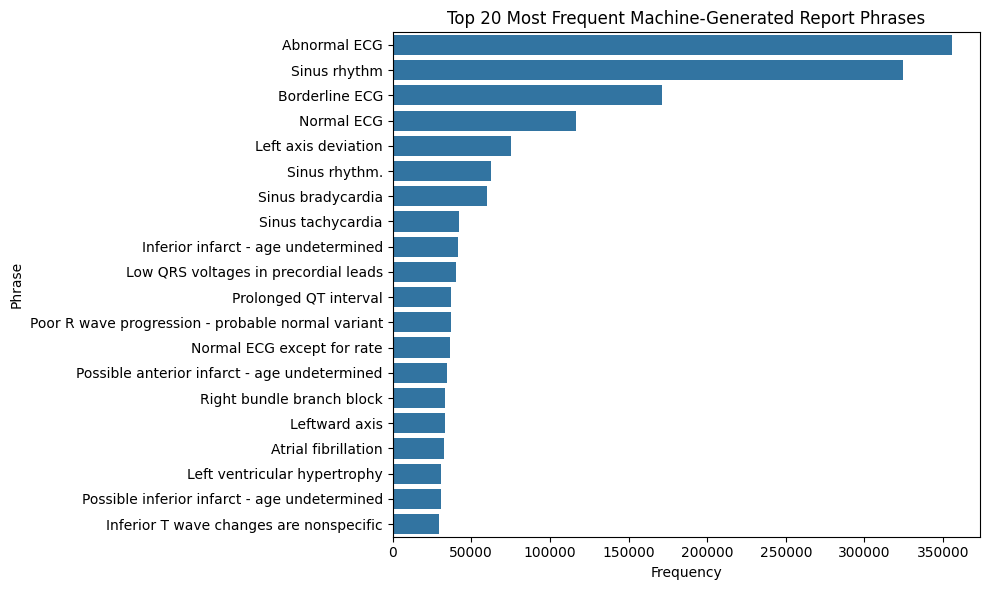

In [ ]:
#Visualize top n phrases for all reports
import seaborn as sns
import matplotlib.pyplot as plt
value_counts.head(20).style.bar(subset=["n"], color='lightgreen')
top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(y='raw_text', x='n', data=value_counts.head(top_n))
plt.title(f"Top {top_n} Most Frequent Machine-Generated Report Phrases")
plt.xlabel("Frequency")
plt.ylabel("Phrase")
plt.tight_layout()
plt.show()

In [ ]:
value_counts.to_csv("ecg_unique_phrases.csv", index=False)
print("Wrote ecg_unique_phrases.csv")


Wrote ecg_unique_phrases.csv


In [ ]:
INPUT_CSV_FILE = 'ecg_unique_phrases.csv'
OUTPUT_CSV_FILE = 'ecg_categorized_phrases.csv'

In [ ]:

# --- Normalization Function ---
def normalize_phrase(text):
    """Cleans and standardizes the ECG phrase."""
    if pd.isna(text) or not isinstance(text, str):
        return "" # Handle NaN or non-string data

    text = text.lower()
    # Remove *** ... *** and --- ... --- wrappers
    text = re.sub(r'^\*+\s?(.*?)\s?\*+$', r'\1', text)
    text = re.sub(r'^---\s?(.*?)\s?---$', r'\1', text)

    # Standardize common abbreviations BEFORE removing punctuation
    replacements = {
        'st-t': 'st t',
        'a-v': 'av',
        'v-rate': 'ventricular rate',
        'afib/flut': 'atrial fibrillation/flutter',
        'afib': 'atrial fibrillation',
        'a fib': 'atrial fibrillation',
        'a flut': 'atrial flutter',
        'mi ': 'myocardial infarction ', # Space ensures whole word
        'lvh': 'left ventricular hypertrophy',
        'rvh': 'right ventricular hypertrophy',
        'lae': 'left atrial enlargement',
        'rae': 'right atrial enlargement',
        'lafb': 'left anterior fascicular block',
        'lpfb': 'left posterior fascicular block',
        'rbbb': 'right bundle branch block',
        'lbbb': 'left bundle branch block',
        'irbbb': 'incomplete right bundle branch block',
        'ilbbb': 'incomplete left bundle branch block',
        'ivcd': 'intraventricular conduction delay', # or defect
        'pvc(s)': 'pvc',
        'pac(s)': 'pac',
        'svt': 'supraventricular tachycardia',
        'abnrm': 'abnormality',
        'abnormalities': 'abnormality',
        'repol ': 'repolarization ',
        'depr ': 'depression ',
        'elev ': 'elevation ',
        'infarct ': 'infarction ',
        'lds': 'leads',
        'ant ': 'anterior ',
        'inf ': 'inferior ',
        'lat ': 'lateral ',
        'sept ': 'septal ',
        'post ': 'posterior ',
        'ext ': 'extremity ', # Careful: could also be extensive
        'precor ': 'precordial ',
        'nonspecific': 'non specific', # Standardize spacing
        'non-specific': 'non specific',
        'ist': 'sinus tachycardia', # Common abbreviation
        'isb': 'sinus bradycardia', # Common abbreviation
        'sr': 'sinus rhythm', # Common abbreviation
         'vt': 'ventricular tachycardia',
         'vf': 'ventricular fibrillation', # Though not in sample data
         'bvh': 'biventricular hypertrophy',
         'avb': 'av block'
    }
    for old, new in replacements.items():
        # Use regex to replace whole words/patterns where appropriate
        text = re.sub(r'\b' + re.escape(old) + r'\b', new, text)

    # Remove punctuation (keep spaces, handle ' like in rSr')
    # Preserve numbers, letters, spaces, and apostrophe within words
    text = re.sub(r'[^\w\s\'/]', ' ', text)
    # Handle potential "r sr'" vs "rsr'" - let's remove internal ' for simplicity here
    text = text.replace("'", "")
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Specific pattern cleanups
    text = text.replace(' summary ', ' ') # Remove summary prefix if missed
    text = text.replace(' consider ', ' ')
    text = text.replace(' probable ', ' ')
    text = text.replace(' possible ', ' ')
    text = text.replace(' suggests ', ' ')

    # Final whitespace cleanup
    text = re.sub(r'\s+', ' ', text).strip()

    # Handle empty strings after cleaning
    if not text:
        return "unspecified_blank"

    return text


In [ ]:

# --- Categorization Function ---
def categorize_phrase(norm_text):
    """Assigns a category based on keywords in the normalized phrase."""

    # Prioritize Technical/Metadata/Warnings
    if re.search(r'#name\?|unsuitable|warning data quality|error|report made without knowing|age not entered|sex not entered|pacer detection suspended|technically unsatisfactory|recording unsuitable|sequence error|magnet in place|no further analysis|no analysis attempted|analysis error|cannot analyze|missing lead|complex qrs morphology no further analysis|measurement error|suspect lead reversal|dextrocardia|artifact|baseline wander', norm_text):
        return "Technical/Metadata/Warning"
    if re.search(r'pediatric criteria used', norm_text):
         return "Technical/Metadata/Warning" # Keep separate maybe?

    # Prioritize Acute MI/Injury Warnings
    if re.search(r'acute st elevation myocardial infarction|consider acute infarction|consider acute st elevation|consider injury|possibly acute|probable acute|recent infarction|strongly suggests myocardial injury|acute changes', norm_text):
         # Further refine by location? For now, general category.
         return "Ischemia/Injury/Acute MI Warning"
    if re.search(r'st elevation consider.*infarction|st depression consider.*infarction', norm_text):
         return "Ischemia/Injury/Acute MI Warning"

    # Specific Findings - Infarction (check before ischemia)
    if re.search(r'infarction|myocardial infarction', norm_text):
        # Could sub-categorize by location/age if needed
        return "Infarction (MI)"

    # Specific Findings - Conduction Blocks
    if re.search(r'(right|left) bundle branch block', norm_text):
        return "Conduction - Bundle Branch Block"
    if re.search(r'fascicular block', norm_text):
        return "Conduction - Fascicular Block"
    if re.search(r'av block|a-v block|av dissociation|wenckebach|mobitz', norm_text):
         # Exclude borderline/1st degree if handled separately
         if not re.search(r'(1st|first) degree av block|prolonged pr|borderline.*av block', norm_text):
              return "Conduction - AV Block (Higher Degree)"
    if re.search(r'intraventricular conduction delay|ivcd|intraventricular conduction defect', norm_text):
        return "Conduction - IVCD/Delay"
    if re.search(r'wpw|wolff parkinson white|preexcitation|delta wave', norm_text):
        return "Conduction - Pre-excitation (WPW)"

    # Specific Findings - Hypertrophy/Enlargement
    if re.search(r'ventricular hypertrophy|lvh|rvh', norm_text):
        return "Hypertrophy - Ventricular"
    if re.search(r'atrial enlargement|atrial abnormality|lae|rae', norm_text):
        return "Enlargement/Abnormality - Atrial"

    # Specific Findings - Ischemia/ST-T changes (Non-acute warnings)
    if re.search(r'isch(emia|emic)|repolarization abnormality|st t changes|st changes|t wave changes|st depression|st elevation|t wave inversion|repol abnormality', norm_text):
         # Exclude "non specific" which is handled later, and MI/Infarction handled above
         if not re.search(r'non specific', norm_text) and not re.search(r'infarction', norm_text):
             # Also exclude early repol if desired
             if not re.search(r'early repol', norm_text):
                 return "Ischemia/ST-T Changes (Suggestive)"
    if re.search(r'early repol', norm_text):
        return "ST-T Changes - Early Repolarization"

    # Rhythm - Atrial Fibrillation/Flutter
    if re.search(r'atrial fibrillation|atrial flutter', norm_text):
        return "Rhythm - Atrial Fibrillation/Flutter"

    # Rhythm - Paced
    if re.search(r'pacemaker|pacing|paced', norm_text):
        return "Rhythm - Paced"

    # Rhythm - Supraventricular/Junctional/Ectopic (Non-Sinus, Non-AF)
    if re.search(r'supraventricular tachycardia|junctional|ectopic atrial|idioventricular', norm_text):
         # Check it's not just PVC/PAC description
         if not re.search(r'pvc|pac|premature complex|extrasystole', norm_text):
             return "Rhythm - SVT/Junctional/Ectopic"
         # If it *does* have PVC/PAC, might still be primary rhythm
         if re.search(r'^(supraventricular|junctional|ectopic atrial|idioventricular)', norm_text):
              return "Rhythm - SVT/Junctional/Ectopic"


    # Rhythm - Sinus (Check relatively late)
    if re.search(r'sinus rhythm|sinus bradycardia|sinus tachycardia|sinus arrhythmia', norm_text):
        # Check it's not primarily about a block/infarct mentioned earlier
        # This check is complex; assume for now if it starts with 'sinus' it's primarily sinus
        if re.search(r'^sinus', norm_text):
             # Could sub-categorize sinus types later if needed
             return "Rhythm - Sinus"

    # Axis Deviation
    if re.search(r'axis deviation|axis', norm_text):
        return "Axis Deviation"

    # Intervals
    if re.search(r'(pr|qt|qtc) interval', norm_text):
        return "Intervals (PR/QT)"
    # Catch 1st degree AV block here if not under higher degree blocks
    if re.search(r'(1st|first) degree av block|prolonged pr', norm_text):
        return "Intervals (PR/QT)" # Or Conduction - AV Block (1st Degree)

    # Voltage Issues
    if re.search(r'voltage', norm_text):
        return "Voltage Issues"

    # Premature Complexes (as primary finding if not part of other rhythm)
    if re.search(r'pvc|pac|premature complex|extrasystole|bigeminy|trigeminy|couplet|multifocal', norm_text):
         # Check if it's *just* about the premature complexes
         if not re.search(r'sinus|atrial fib|atrial flut|pacing|paced|junctional|supraventricular', norm_text):
              return "Premature Complexes"

    # Specific Patterns/Other Findings
    if re.search(r'poor r wave progression|rsr pattern|s1 s2 s3 pattern', norm_text):
         return "Specific Patterns/Other"

    # Non-specific ST/T changes (check late)
    if re.search(r'non specific.*(st|t wave|repolarization)', norm_text):
        return "ST-T Changes - Non-specific"

    # Overall Assessment (check last before 'Uncategorized')
    if re.search(r'^(normal|abnormal|borderline) ecg', norm_text):
        return "Overall Assessment"
    if norm_text == 'within normal limits':
         return "Overall Assessment"

    # Default Category
    return "Uncategorized"


In [ ]:

# --- Main Processing ---
print(f"Reading {INPUT_CSV_FILE}...")
try:
    df = pd.read_csv(INPUT_CSV_FILE)
    # Ensure 'n' is numeric, coerce errors to NaN then fill with 0
    df['n'] = pd.to_numeric(df['n'], errors='coerce').fillna(0).astype(int)
    # Drop rows where count became 0 if desired (e.g., if 'n' was non-numeric)
    df = df[df['n'] > 0]
except FileNotFoundError:
    print(f"Error: Input file '{INPUT_CSV_FILE}' not found.")
    exit()
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

print("Normalizing phrases...")
df['normalized_text'] = df['raw_text'].apply(normalize_phrase)

print("Consolidating phrases and summing counts...")
# Group by normalized text, sum counts, and keep a list of original texts
consolidated_df = df.groupby('normalized_text').agg(
    total_n=('n', 'sum'),
    original_phrases=('raw_text', lambda x: list(set(x))) # Use set to get unique originals
).reset_index()

# Sort by count descending
consolidated_df = consolidated_df.sort_values('total_n', ascending=False).reset_index(drop=True)

print("Categorizing phrases...")
consolidated_df['category'] = consolidated_df['normalized_text'].apply(categorize_phrase)

print("\n--- Categorized ECG Phrases ---")

# Display results grouped by category
grouped = consolidated_df.groupby('category')

for category_name, group_df in grouped:
    print(f"\n=== Category: {category_name} ===")
    # Sort within category by count
    group_df_sorted = group_df.sort_values('total_n', ascending=False).reset_index(drop=True)
    # Print top N or all for each category
    for index, row in group_df_sorted.head(20).iterrows(): # Print top 20 per category
         # Truncate long original phrase lists for display
         orig_phrases_display = ', '.join(map(str, row['original_phrases'][:3]))
         if len(row['original_phrases']) > 3:
              orig_phrases_display += '...'
         print(f"- {row['normalized_text']} (Count: {row['total_n']})")
         # Optionally print some original phrases for context
         # print(f"    Originals: [{orig_phrases_display}]")
    if len(group_df) > 20:
         print(f"  ... (and {len(group_df) - 20} more)")


# Save the categorized results to a new CSV
if OUTPUT_CSV_FILE:
    print(f"\nSaving categorized results to {OUTPUT_CSV_FILE}...")
    try:
        # Convert list of original phrases to string for CSV compatibility
        consolidated_df['original_phrases_str'] = consolidated_df['original_phrases'].apply(lambda x: ' | '.join(map(str, x)))
        consolidated_df[['category', 'normalized_text', 'total_n', 'original_phrases_str']].to_csv(OUTPUT_CSV_FILE, index=False)
        print("Saved successfully.")
    except Exception as e:
        print(f"Error saving file: {e}")

print("\nProcessing complete.")

In [ ]:
import pandas as pd
import numpy as np
import re
import collections

# --- Configuration ---
UNIQUE_PHRASES_CSV = 'ecg_unique_phrases.csv' # Input for building maps

# --- Normalization Function (same as previous script) ---
def normalize_phrase(text):
    """Cleans and standardizes the ECG phrase."""
    if pd.isna(text) or not isinstance(text, str):
        return "" # Handle NaN or non-string data
    text = text.lower()
    text = re.sub(r'^\*+\s?(.*?)\s?\*+$', r'\1', text)
    text = re.sub(r'^---\s?(.*?)\s?---$', r'\1', text)
    replacements = {
        'st-t': 'st t', 'a-v': 'av', 'v-rate': 'ventricular rate',
        'afib/flut': 'atrial fibrillation/flutter', 'afib': 'atrial fibrillation',
        'a fib': 'atrial fibrillation', 'a flut': 'atrial flutter',
        'mi ': 'myocardial infarction ', 'lvh': 'left ventricular hypertrophy',
        'rvh': 'right ventricular hypertrophy', 'lae': 'left atrial enlargement',
        'rae': 'right atrial enlargement', 'lafb': 'left anterior fascicular block',
        'lpfb': 'left posterior fascicular block', 'rbbb': 'right bundle branch block',
        'lbbb': 'left bundle branch block', 'irbbb': 'incomplete right bundle branch block',
        'ilbbb': 'incomplete left bundle branch block', 'ivcd': 'intraventricular conduction delay',
        'pvc(s)': 'pvc', 'pac(s)': 'pac', 'svt': 'supraventricular tachycardia',
        'abnrm': 'abnormality', 'abnormalities': 'abnormality', 'repol ': 'repolarization ',
        'depr ': 'depression ', 'elev ': 'elevation ', 'infarct ': 'infarction ',
        'lds': 'leads', 'ant ': 'anterior ', 'inf ': 'inferior ', 'lat ': 'lateral ',
        'sept ': 'septal ', 'post ': 'posterior ', 'ext ': 'extremity ',
        'precor ': 'precordial ', 'nonspecific': 'non specific', 'non-specific': 'non specific',
        'ist': 'sinus tachycardia', 'isb': 'sinus bradycardia', 'sr': 'sinus rhythm',
        'vt': 'ventricular tachycardia', 'vf': 'ventricular fibrillation',
        'bvh': 'biventricular hypertrophy', 'avb': 'av block'
    }
    for old, new in replacements.items():
        text = re.sub(r'\b' + re.escape(old) + r'\b', new, text)
    text = re.sub(r'[^\w\s\'\/]', ' ', text)
    text = text.replace("'", "")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace(' summary ', ' ')
    text = text.replace(' consider ', ' ')
    text = text.replace(' probable ', ' ')
    text = text.replace(' possible ', ' ')
    text = text.replace(' suggests ', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    if not text: return "unspecified_blank"
    return text


# --- Categorization Function (same as previous script) ---
def categorize_phrase(norm_text):
    """Assigns a category based on keywords in the normalized phrase."""
    if re.search(r'#name\?|unsuitable|warning data quality|error|report made without knowing|age not entered|sex not entered|pacer detection suspended|technically unsatisfactory|recording unsuitable|sequence error|magnet in place|no further analysis|no analysis attempted|analysis error|cannot analyze|missing lead|complex qrs morphology no further analysis|measurement error|suspect lead reversal|dextrocardia|artifact|baseline wander|pediatric criteria used', norm_text):
        return "Technical/Metadata/Warning"
    if re.search(r'acute st elevation myocardial infarction|consider acute infarction|consider acute st elevation|consider injury|possibly acute|probable acute|recent infarction|strongly suggests myocardial injury|acute changes|st elevation consider.*infarction|st depression consider.*infarction', norm_text):
        return "Ischemia/Injury/Acute MI Warning"
    if re.search(r'infarction|myocardial infarction', norm_text): return "Infarction (MI)"
    if re.search(r'(right|left) bundle branch block', norm_text): return "Conduction - Bundle Branch Block"
    if re.search(r'fascicular block', norm_text): return "Conduction - Fascicular Block"
    if re.search(r'av block|av dissociation|wenckebach|mobitz', norm_text) and not re.search(r'(1st|first) degree av block|prolonged pr|borderline.*av block', norm_text): return "Conduction - AV Block (Higher Degree)"
    if re.search(r'intraventricular conduction delay|ivcd', norm_text): return "Conduction - IVCD/Delay"
    if re.search(r'wpw|wolff parkinson white|preexcitation|delta wave', norm_text): return "Conduction - Pre-excitation (WPW)"
    if re.search(r'ventricular hypertrophy|lvh|rvh', norm_text): return "Hypertrophy - Ventricular"
    if re.search(r'atrial enlargement|atrial abnormality|lae|rae', norm_text): return "Enlargement/Abnormality - Atrial"
    if re.search(r'isch(emia|emic)|repolarization abnormality|st t changes|st changes|t wave changes|st depression|st elevation|t wave inversion|repol abnormality', norm_text) and not re.search(r'non specific|infarction|early repol', norm_text): return "Ischemia/ST-T Changes (Suggestive)"
    if re.search(r'early repol', norm_text): return "ST-T Changes - Early Repolarization"
    if re.search(r'atrial fibrillation|atrial flutter', norm_text): return "Rhythm - Atrial Fibrillation/Flutter"
    if re.search(r'pacemaker|pacing|paced', norm_text): return "Rhythm - Paced"
    # Check for main rhythm type, avoid solely PVC/PAC descriptions
    if re.search(r'\b(supraventricular tachycardia|junctional rhythm|accelerated idioventricular|idioventricular rhythm|ectopic atrial tachycardia|ectopic atrial rhythm)\b', norm_text) and not re.search(r'pvc|pac|premature complex|extrasystole', norm_text): return "Rhythm - SVT/Junctional/Ectopic"
    if re.search(r'^sinus (rhythm|bradycardia|tachycardia|arrhythmia)', norm_text): return "Rhythm - Sinus"
    if re.search(r'axis deviation|axis', norm_text): return "Axis Deviation"
    if re.search(r'(pr|qt|qtc) interval', norm_text): return "Intervals (PR/QT)"
    if re.search(r'(1st|first) degree av block|prolonged pr', norm_text): return "Intervals (PR/QT)"
    if re.search(r'voltage', norm_text): return "Voltage Issues"
    if re.search(r'pvc|pac|premature complex|extrasystole|bigeminy|trigeminy|couplet|multifocal', norm_text) and not re.search(r'sinus|atrial fib|atrial flut|pacing|paced|junctional|supraventricular', norm_text): return "Premature Complexes"
    if re.search(r'poor r wave progression|rsr pattern|s1 s2 s3 pattern', norm_text): return "Specific Patterns/Other"
    if re.search(r'non specific.*(st|t wave|repolarization)', norm_text): return "ST-T Changes - Non-specific"
    if re.search(r'^(normal|abnormal|borderline) ecg|within normal limits', norm_text): return "Overall Assessment"
    return "Uncategorized"


# --- Build Mappings ---
print(f"Loading unique phrases from {UNIQUE_PHRASES_CSV} to build maps...")
try:
    unique_phrases_df = pd.read_csv(UNIQUE_PHRASES_CSV)
    if 'raw_text' not in unique_phrases_df.columns: raise ValueError("'raw_text' column missing")
except FileNotFoundError: print(f"Error: File '{UNIQUE_PHRASES_CSV}' not found."); exit()
except Exception as e: print(f"Error reading {UNIQUE_PHRASES_CSV}: {e}"); exit()

print("Normalizing and categorizing unique phrases...")
unique_phrases_df['normalized_text'] = unique_phrases_df['raw_text'].apply(normalize_phrase)
unique_phrases_df['category'] = unique_phrases_df['normalized_text'].apply(categorize_phrase)

print("Building mapping dictionaries...")
raw_to_normalized_map = {}
raw_to_category_map = {}
for index, row in unique_phrases_df.iterrows():
    raw, norm, cat = row['raw_text'], row['normalized_text'], row['category']
    if isinstance(raw, str) and raw.strip():
        if raw not in raw_to_normalized_map: raw_to_normalized_map[raw] = norm
        if raw not in raw_to_category_map: raw_to_category_map[raw] = cat
print(f"Built mappings for {len(raw_to_normalized_map)} unique raw phrases.")

# --- Aggregation Logic ---
report_columns = [col for col in measure_df.columns if col.startswith('report_')]
if not report_columns: print("Error: No 'report_x' columns found."); exit()
print(f"\nProcessing {len(report_columns)} report columns for aggregation.")

# Define Target Features and Defaults - Updated for Infarct
feature_defaults = {
    'Final_Rhythm': 'Not Specified',
    'Final_Axis': 'Normal/Not Specified',
    'Final_Conduction_BBB': 'Absent',
    'Final_Conduction_Fascicular': 'Absent',
    'Final_Conduction_AVBlock': 'None',
    'Final_Hypertrophy_LVH': 'Absent',
    'Final_Hypertrophy_RVH': 'Absent',
    'Final_Enlargement_LAE': 'Absent',
    'Final_Enlargement_RAE': 'Absent',
    'Final_Infarct': 'Absent/Not Mentioned', # Consolidated Infarct column
    'Final_Ischemia_STT': 'Normal/Not Specified',
    'Final_Voltage': 'Normal',
    'Final_PrematureBeats': 'None',
    'Final_WPW': 'Absent',
    'Final_Technical_Issue': 'Absent'
}

# --- Helper to Parse Single Infarct Phrase ---
def parse_infarct_phrase(norm_phrase):
    if 'infarction' not in norm_phrase:
        return None

    # 1. Certainty
    certainty = 'Present' # Default if infarct mentioned
    if 'possible' in norm_phrase or 'suggests' in norm_phrase or 'cannot rule out' in norm_phrase:
        certainty = 'Possible'

    # 2. Age
    age = 'Undetermined' # Default age if infarct mentioned
    if 'acute' in norm_phrase or 'recent' in norm_phrase:
        age = 'Acute/Recent'
    elif 'old' in norm_phrase:
        age = 'Old'
    # Implicit 'Undetermined' if 'age undetermined' or 'age indeterminate' is present or no age term found

    # 3. Location
    locations = set()
    # Use positive lookahead/behind or careful ordering if needed for overlaps
    if 'anteroseptal' in norm_phrase: locations.add('Anteroseptal')
    if 'anterolateral' in norm_phrase: locations.add('Anterolateral')
    if 'inferior' in norm_phrase: locations.add('Inferior')
    # Check general terms only if specific ones aren't present for that region
    if 'anterior' in norm_phrase and not locations.intersection({'Anteroseptal', 'Anterolateral'}): locations.add('Anterior')
    if 'lateral' in norm_phrase and 'Anterolateral' not in locations: locations.add('Lateral')
    if 'septal' in norm_phrase and 'Anteroseptal' not in locations: locations.add('Septal')
    if 'posterior' in norm_phrase: locations.add('Posterior')
    if 'extensive' in norm_phrase: locations.add('Extensive')

    if not locations:
        location_str = 'Unspecified Location'
    elif 'Extensive' in locations:
         location_str = 'Extensive' # Override if extensive
    else:
        location_str = '+'.join(sorted(list(locations)))

    # Assign priority score (higher is more important)
    priority = 0
    if age == 'Acute/Recent': priority += 10
    elif age == 'Old': priority += 5
    else: priority += 1 # Undetermined

    if certainty == 'Present': priority += 2
    else: priority += 0 # Possible is baseline within age

    return {'certainty': certainty, 'age': age, 'location': location_str, 'priority': priority, 'raw_norm': norm_phrase}

# --- New Consolidated Infarct Determination Function ---
def determine_final_infarct(norm_phrases):
    infarct_findings = []
    for phrase in norm_phrases:
        parsed = parse_infarct_phrase(phrase)
        if parsed:
            infarct_findings.append(parsed)

    if not infarct_findings:
        return feature_defaults['Final_Infarct'] # Absent/Not Mentioned

    # Find the highest priority level among all findings
    max_priority = 0
    for finding in infarct_findings:
        if finding['priority'] > max_priority:
            max_priority = finding['priority']

    # Filter findings to only those matching the highest priority
    highest_priority_findings = [f for f in infarct_findings if f['priority'] == max_priority]

    if not highest_priority_findings: # Should not happen if infarct_findings is not empty
        return feature_defaults['Final_Infarct']

    # Determine characteristics from the highest priority group
    # Use the age/certainty from the first finding in the high priority group (they should be consistent by design)
    primary_finding = highest_priority_findings[0]
    final_age = primary_finding['age']
    final_certainty = primary_finding['certainty']

    # Combine all locations from the highest priority group
    final_locations = set()
    is_extensive = False
    for finding in highest_priority_findings:
        if finding['location'] == 'Extensive':
            is_extensive = True
            break # Extensive takes precedence
        elif finding['location'] != 'Unspecified Location':
            # Split combined locations if they exist from parsing
            final_locations.update(finding['location'].split('+'))

    if is_extensive:
        final_location_str = 'Extensive'
    elif not final_locations:
         final_location_str = 'Unspecified Location'
    else:
        final_location_str = '+'.join(sorted(list(final_locations)))

    # Format the final string
    if final_certainty == 'Possible':
        # For possible, maybe simplify and just report location + possible
        return f"{final_location_str} - Possible/Suggestive"
    else: # Present certainty
        # Use the determined age
        return f"{final_location_str} - {final_age}"


# --- Other determine_final_xxx functions (ensure they are copied here) ---
# determine_final_rhythm, determine_final_axis, determine_final_bbb, etc.
def determine_final_rhythm(norm_phrases):
    is_paced = any('paced' in p or 'pacing' in p for p in norm_phrases)
    is_afib_flutter = any('atrial fibrillation' in p or 'atrial flutter' in p for p in norm_phrases)
    if is_paced and is_afib_flutter: return 'Paced (with AFib/Flutter)'
    if is_paced: return 'Paced'
    if any('ventricular tachycardia' in p for p in norm_phrases): return 'Ventricular Tachycardia'
    if is_afib_flutter:
         if any('atrial fibrillation' in p for p in norm_phrases): return 'Atrial Fibrillation'
         if any('atrial flutter' in p for p in norm_phrases): return 'Atrial Flutter'
    if any(re.search(r'\b(supraventricular tachycardia|junctional rhythm|accelerated idioventricular|idioventricular rhythm)\b', p) for p in norm_phrases): return 'SVT/Junctional/Idioventricular'
    if any('ectopic atrial tachycardia' in p for p in norm_phrases): return 'Ectopic Atrial Tachycardia'
    if any('ectopic atrial rhythm' in p for p in norm_phrases): return 'Ectopic Atrial Rhythm'
    if any('sinus bradycardia' in p for p in norm_phrases): return 'Sinus Bradycardia'
    if any('sinus tachycardia' in p for p in norm_phrases): return 'Sinus Tachycardia'
    if any('sinus arrhythmia' in p for p in norm_phrases): return 'Sinus Arrhythmia'
    if any('sinus rhythm' in p for p in norm_phrases): return 'Sinus Rhythm'
    return feature_defaults['Final_Rhythm']

def determine_final_axis(norm_phrases):
    if any('left axis deviation' in p or 'leftward axis' in p for p in norm_phrases): return 'Left'
    if any('right axis deviation' in p or 'rightward axis' in p for p in norm_phrases): return 'Right'
    if any('indeterminate axis' in p or 'extreme axis' in p for p in norm_phrases): return 'Indeterminate/Extreme'
    return feature_defaults['Final_Axis']

def determine_final_bbb(norm_phrases):
    if any('left bundle branch block' in p for p in norm_phrases): return 'LBBB'
    if any('right bundle branch block' in p for p in norm_phrases): return 'RBBB'
    if any('incomplete left bundle branch block' in p for p in norm_phrases): return 'Incomplete LBBB'
    if any('incomplete right bundle branch block' in p for p in norm_phrases): return 'Incomplete RBBB'
    if any('intraventricular conduction delay' in p or 'ivcd' in p for p in norm_phrases): return 'IVCD'
    return feature_defaults['Final_Conduction_BBB']

def determine_final_fascicular(norm_phrases):
    if any('left anterior fascicular block' in p for p in norm_phrases): return 'LAFB'
    if any('left posterior fascicular block' in p for p in norm_phrases): return 'LPFB'
    return feature_defaults['Final_Conduction_Fascicular']

def determine_final_av_block(norm_phrases):
    if any('3rd degree av block' in p or 'third degree av block' in p or 'complete av block' in p for p in norm_phrases): return '3rd Degree'
    if any('mobitz ii' in p or 'mobitz 2' in p for p in norm_phrases): return '2nd Degree Mobitz II'
    if any('mobitz i' in p or 'wenckebach' in p for p in norm_phrases): return '2nd Degree Mobitz I'
    if any('2nd degree av block' in p for p in norm_phrases): return '2nd Degree (Unspecified)'
    if any('1st degree av block' in p or 'first degree av block' in p for p in norm_phrases): return '1st Degree'
    if any('borderline.*av block' in p or 'prolonged pr' in p for p in norm_phrases): return 'Borderline/Prolonged PR'
    return feature_defaults['Final_Conduction_AVBlock']

def determine_final_lvh(norm_phrases):
    if any('left ventricular hypertrophy' in p and 'possible' not in p and 'suggests' not in p for p in norm_phrases): return 'Present'
    if any('possible left ventricular hypertrophy' in p or 'suggests left ventricular hypertrophy' in p for p in norm_phrases): return 'Possible/Suggestive'
    if any('voltage criteria.*left ventricular hypertrophy' in p for p in norm_phrases): return 'Voltage Criteria Only'
    return feature_defaults['Final_Hypertrophy_LVH']

def determine_final_rvh(norm_phrases):
    if any('right ventricular hypertrophy' in p and 'possible' not in p and 'suggests' not in p for p in norm_phrases): return 'Present'
    if any('possible right ventricular hypertrophy' in p or 'suggests right ventricular hypertrophy' in p for p in norm_phrases): return 'Possible/Suggestive'
    return feature_defaults['Final_Hypertrophy_RVH']

def determine_final_lae(norm_phrases):
    if any('left atrial enlargement' in p and 'possible' not in p and 'suggests' not in p for p in norm_phrases): return 'Present'
    if any('possible left atrial enlargement' in p or 'suggests left atrial enlargement' in p or 'left atrial abnormality' in p for p in norm_phrases): return 'Possible/Suggestive/Abnormal'
    return feature_defaults['Final_Enlargement_LAE']

def determine_final_rae(norm_phrases):
    if any('right atrial enlargement' in p and 'possible' not in p and 'suggests' not in p for p in norm_phrases): return 'Present'
    if any('possible right atrial enlargement' in p or 'suggests right atrial enlargement' in p or 'right atrial abnormality' in p for p in norm_phrases): return 'Possible/Suggestive/Abnormal'
    return feature_defaults['Final_Enlargement_RAE']

def determine_ischemia_stt(norm_phrases):
    if any('isch' in p or 'injury' in p for p in norm_phrases if 'st' in p or 't wave' in p): return 'Suggestive Ischemia/Injury'
    if any('st elevation' in p or 'st depression' in p for p in norm_phrases if 'non specific' not in p and 'early repol' not in p): return 'Suggestive ST Deviation'
    if any('t wave inversion' in p for p in norm_phrases if 'non specific' not in p): return 'Suggestive T Inversion'
    if any('early repol' in p for p in norm_phrases): return 'Early Repolarization'
    if any('non specific' in p for p in norm_phrases if 'st' in p or 't wave' in p): return 'Non-Specific ST/T Changes'
    if any('st t' in p or 'st change' in p or 't wave change' in p for p in norm_phrases): return 'Other ST/T Finding'
    return feature_defaults['Final_Ischemia_STT']

def determine_voltage(norm_phrases):
    if any('low voltage' in p for p in norm_phrases): return 'Low'
    if any('high voltage' in p for p in norm_phrases): return 'High'
    return feature_defaults['Final_Voltage']

def determine_premature_beats(norm_phrases):
    has_pvc = any('pvc' in p or 'ventricular premature' in p for p in norm_phrases)
    has_pac = any('pac' in p or 'atrial premature' in p for p in norm_phrases)
    if has_pvc and has_pac: return 'PVC+PAC'
    if has_pvc: return 'PVC'
    if has_pac: return 'PAC'
    return feature_defaults['Final_PrematureBeats']

def determine_wpw(norm_phrases):
    if any('wpw' in p or 'wolff parkinson white' in p or 'preexcitation' in p for p in norm_phrases): return 'Present'
    return feature_defaults['Final_WPW']

def determine_technical_issue(raw_phrases_for_row): # Use raw phrases + category map
    global raw_to_category_map
    categories = {raw_to_category_map.get(raw) for raw in raw_phrases_for_row if raw in raw_to_category_map}
    if 'Technical/Metadata/Warning' in categories: return 'Present'
    return feature_defaults['Final_Technical_Issue']
# --- End of determine_final_xxx functions ---


# --- Row Processing Function - Updated ---
def process_ecg_row(row):
    global raw_to_normalized_map, raw_to_category_map # Access global maps

    raw_phrases_for_row = set()
    for col in report_columns:
        val = row[col]
        if pd.notna(val) and isinstance(val, str) and val.strip():
            raw_phrases_for_row.add(val)

    normalized_phrases_for_row = set()
    if raw_phrases_for_row:
        for raw in raw_phrases_for_row:
            norm = raw_to_normalized_map.get(raw)
            if norm and norm != "unspecified_blank":
                normalized_phrases_for_row.add(norm)

    results = {}
    # Call determination functions
    results['Final_Rhythm'] = determine_final_rhythm(normalized_phrases_for_row)
    results['Final_Axis'] = determine_final_axis(normalized_phrases_for_row)
    results['Final_Conduction_BBB'] = determine_final_bbb(normalized_phrases_for_row)
    results['Final_Conduction_Fascicular'] = determine_final_fascicular(normalized_phrases_for_row)
    results['Final_Conduction_AVBlock'] = determine_final_av_block(normalized_phrases_for_row)
    results['Final_Hypertrophy_LVH'] = determine_final_lvh(normalized_phrases_for_row)
    results['Final_Hypertrophy_RVH'] = determine_final_rvh(normalized_phrases_for_row)
    results['Final_Enlargement_LAE'] = determine_final_lae(normalized_phrases_for_row)
    results['Final_Enlargement_RAE'] = determine_final_rae(normalized_phrases_for_row)
    results['Final_Infarct'] = determine_final_infarct(normalized_phrases_for_row) # Use new function
    results['Final_Ischemia_STT'] = determine_ischemia_stt(normalized_phrases_for_row)
    results['Final_Voltage'] = determine_voltage(normalized_phrases_for_row)
    results['Final_PrematureBeats'] = determine_premature_beats(normalized_phrases_for_row)
    results['Final_WPW'] = determine_wpw(normalized_phrases_for_row)
    results['Final_Technical_Issue'] = determine_technical_issue(raw_phrases_for_row)

    # Ensure all feature keys are present
    for key, default_val in feature_defaults.items():
        if key not in results: results[key] = default_val

    return pd.Series(results)

# --- Apply the function ---
print("\nApplying row-wise processing to determine final features for measure_df...")
# from tqdm.auto import tqdm # Optional progress bar
# tqdm.pandas()
# final_features_df = measure_df.progress_apply(process_ecg_row, axis=1)
final_features_df = measure_df.apply(process_ecg_row, axis=1) # Standard apply

print("\nJoining final features back to measure_df...")

# Identify columns to potentially drop (the ones we are about to add)
cols_to_drop = final_features_df.columns.tolist()
# Find which of these actually exist in measure_df
existing_cols_to_drop = [col for col in cols_to_drop if col in measure_df.columns]
if existing_cols_to_drop:
    print(f"Dropping pre-existing columns before join: {existing_cols_to_drop}")
    measure_df = measure_df.drop(columns=existing_cols_to_drop)

# Join the new features back to the original dataframe
measure_df = measure_df.join(final_features_df) # Joining assumes index alignment

print("\nProcessing complete. New 'Final_xxx' feature columns added.")

# --- Display Results ---
print("\nSample of measure_df with NEW final feature columns:")
new_feature_cols = list(feature_defaults.keys())
display_cols = ['subject_id', 'study_id', 'ecg_time']
display_cols = [c for c in display_cols if c in measure_df.columns]
display_cols.extend(new_feature_cols)
display_cols = [c for c in display_cols if c in measure_df.columns]

if display_cols:
    print(measure_df[display_cols].head())
    print("\nValue counts for Final_Rhythm:")
    if 'Final_Rhythm' in measure_df.columns: print(measure_df['Final_Rhythm'].value_counts(dropna=False).head(15)) # Show top 15
    print("\nValue counts for Final_Infarct:")
    if 'Final_Infarct' in measure_df.columns: print(measure_df['Final_Infarct'].value_counts(dropna=False).head(20)) # Show top 20
else:
    print("Could not determine columns to display sample.")

print("\nFinal measure_df shape:", measure_df.shape)


# --- Save Updated Dataframe ---
final_output_file = '/content/drive/MyDrive/AC209B/RAW_DATA/ECG/measure_df_with_final_features.csv'
print(f"\nSaving updated dataframe with final features to {final_output_file}...")
try:
    measure_df.to_csv(final_output_file, index=False)
    print("Saved successfully.")
except Exception as e:
    print(f"Error saving updated file: {e}")

In [ ]:

print("Displaying value counts for 'Final_xxx' columns...\n")

# 1. Identify the new feature columns
final_feature_columns = [col for col in measure_df.columns if col.startswith('Final_')]

# 2. Check if any columns were found
if not final_feature_columns:
    print("No columns starting with 'Final_' found in the DataFrame.")
    print("Please ensure the previous script ran successfully and added these columns.")
else:
    # 3. Iterate and print value counts for each
    for col_name in final_feature_columns:
        print(f"--- Value Counts for: {col_name} ---")
        try:
            # Get value counts, sorted by count descending
            counts = measure_df[col_name].value_counts(dropna=False)
            print(counts)
        except KeyError:
            print(f"   (Column '{col_name}' not found - unexpected error)")
        except Exception as e:
            print(f"   (An error occurred processing column '{col_name}': {e})")
        print("-" * (len(col_name) + 24)) # Separator line

print("\nValue count display complete.")

In [ ]:
import pandas as pd
import numpy as np

# --- Load the original dataframe ---
try:
    measure_df = pd.read_csv("measure_df_with_final_features.csv")
    print("Successfully loaded measure_df_with_final_features.csv")
except FileNotFoundError:
    print("Error: measure_df_with_final_features.csv not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file isn't found

# --- Create the base output dataframe with identifiers ---
# We select the ID columns first and make a copy to avoid modifying the original df
# unless specifically intended, and to prevent SettingWithCopyWarning.
output_df = measure_df[['subject_id', 'study_id', 'cart_id']].copy()
print(f"Created base output DataFrame with {len(output_df)} rows and columns: {list(output_df.columns)}")

# --- Generate Target Labels ---

# Afib (yes/no)
output_df['Afib'] = (measure_df['Final_Rhythm'] == 'Atrial Fibrillation').astype(int)

# Aflutter (yes/no)
output_df['Aflutter'] = (measure_df['Final_Rhythm'] == 'Atrial Flutter').astype(int)

# Left axis (yes/no)
output_df['Left_axis'] = (measure_df['Final_Axis'] == 'Left').astype(int)

# Right axis (yes/no)
output_df['Right_axis'] = (measure_df['Final_Axis'] == 'Right').astype(int)

# RBBB (yes/no)
output_df['RBBB'] = (measure_df['Final_Conduction_BBB'] == 'RBBB').astype(int)

# LBBB (yes/no)
output_df['LBBB'] = (measure_df['Final_Conduction_BBB'] == 'LBBB').astype(int)

# LAFB (yes/no)
output_df['LAFB'] = (measure_df['Final_Conduction_Fascicular'] == 'LAFB').astype(int)

# 1* AVB (yes/no)
# Considers only '1st Degree'. 'Borderline/Prolonged PR' is treated as 'no'.
output_df['First_Degree_AVB'] = (measure_df['Final_Conduction_AVBlock'] == '1st Degree').astype(int)

# LVH (yes/no)
# Includes 'Present' and 'Possible/Suggestive' as 'yes'
lvh_yes_values = ['Present', 'Possible/Suggestive']
output_df['LVH'] = measure_df['Final_Hypertrophy_LVH'].isin(lvh_yes_values).astype(int)

# RVH (yes/no)
# Includes 'Present' and 'Possible/Suggestive' as 'yes'
rvh_yes_values = ['Present', 'Possible/Suggestive']
output_df['RVH'] = measure_df['Final_Hypertrophy_RVH'].isin(rvh_yes_values).astype(int)

# LAE (yes/no)
# Includes 'Present' and 'Possible/Suggestive/Abnormal' as 'yes'
lae_yes_values = ['Present', 'Possible/Suggestive/Abnormal']
output_df['LAE'] = measure_df['Final_Enlargement_LAE'].isin(lae_yes_values).astype(int)

# RAE (yes/no)
# Includes 'Present' and 'Possible/Suggestive/Abnormal' as 'yes'
rae_yes_values = ['Present', 'Possible/Suggestive/Abnormal']
output_df['RAE'] = measure_df['Final_Enlargement_RAE'].isin(rae_yes_values).astype(int)

# Final_Ischemia: Normal vs all others
# Uses 'Final_Ischemia_STT'. Maps 'Normal/Not Specified' to 'Normal', all others to 'Other'.
output_df['Final_Ischemia'] = np.where(
    measure_df['Final_Ischemia_STT'] == 'Normal/Not Specified',
    1,
    0
)

# PAC (yes/no)
# Includes 'PAC' and 'PVC+PAC' as 'yes'
pac_yes_values = ['PAC', 'PVC+PAC']
output_df['PAC'] = measure_df['Final_PrematureBeats'].isin(pac_yes_values).astype(int)

# PVC (yes/no)
# Includes 'PVC' and 'PVC+PAC' as 'yes'
pvc_yes_values = ['PVC', 'PVC+PAC']
output_df['PVC'] = measure_df['Final_PrematureBeats'].isin(pvc_yes_values).astype(int)

# Voltage (low vs normal/high)
# Maps 'Low' to 'Low', 'Normal' and 'High' to 'Normal/High'.
output_df['Voltage'] = (measure_df['Final_Voltage'] == 'Low').astype(int) # Low=1, others=0


# --- Display Results ---

print("\n--- Resulting DataFrame Head ---")
print(output_df.head(15))
print("\n")

print("--- Resulting DataFrame Info ---")
output_df.info()
print("\n")

print("--- Value Counts for New Target Labels ---")
# Iterate through the newly created columns (excluding the initial ID columns)
for col in output_df.columns[3:]:
    print(f"--- Value Counts for: {col} ---")
    print(output_df[col].value_counts())
    print("-" * (len(col) + 22)) # Separator line

output_df.to_csv("transformed_ecg_labels.csv", index=False)
print("\nSaved transformed labels to transformed_ecg_labels.csv")

In [ ]:
#take transformed_ecg_labels
df= pd.read_csv("transformed_ecg_labels.csv")
print(df.head(15))

In [ ]:
df['Final_Ischemia'] = np.where(
    df['Final_Ischemia'] == 'Normal',
    1,
    0
)

In [ ]:
print(df.head(15))

df.to_csv("transformed_ecg_labels.csv", index=False)
print("\nSaved transformed labels to transformed_ecg_labels.csv")

In [ ]:
#Afib label creation which we decided not to use but will leave here just in case.
'''
measure_df = pd.read_csv("measure_df_with_final_features.csv")

print(measure_df[['subject_id', 'study_id', 'cart_id', 'Final_Rhythm']].head(15)) # Show relevant columns
print("\n")

# --- Step 1: Filter out unwanted rhythms ---
rhythms_to_exclude = ['Paced (with AFib/Flutter)', 'Atrial Flutter']
print(f"Filtering out: {rhythms_to_exclude}")

# Keep rows where Final_Rhythm is NOT in the exclusion list
df_filtered = measure_df[~measure_df['Final_Rhythm'].isin(rhythms_to_exclude)].copy()

print("--- DataFrame after Filtering ---")
print(df_filtered[['subject_id', 'study_id', 'cart_id', 'Final_Rhythm']].head(15))
print("\n")


# --- Step 2: Create the binary label column ---
# Create 'label' column: 1 if 'Atrial Fibrillation', 0 otherwise
target_rhythm = 'Atrial Fibrillation'
print(f"Creating binary label: 1 for '{target_rhythm}', 0 otherwise")

# Method 1 (Concise and efficient): Boolean comparison + conversion to int
df_filtered['label'] = (df_filtered['Final_Rhythm'] == target_rhythm).astype(int)

print("--- DataFrame with Label Added ---")
print(df_filtered[['subject_id', 'study_id', 'cart_id', 'Final_Rhythm', 'label']].head(15))
print("\n")

# --- Step 3: Create the final matrix with ID columns and label ---
id_columns = ['subject_id', 'study_id', 'cart_id']
final_columns = id_columns + ['label']
print(f"Selecting final columns: {final_columns}")

final_matrix_df = df_filtered[final_columns]

print("--- Final Matrix (DataFrame) ---")
print(final_matrix_df.head(15))
print("\n")

# --- Optional: Check label distribution in the final matrix ---
print("--- Label Value Counts in Final Matrix ---")
print(final_matrix_df['label'].value_counts())
'''

In [ ]:
# --- Save Updated Dataframe ---
label_df_file = '/content/drive/MyDrive/AC209B/RAW_DATA/ECG/label_df.csv'
print(f"\nSaving updated dataframe with final features to {label_df_file}...")
try:
    final_matrix_df.to_csv(label_df_file, index=False)
    print("Saved successfully.")
except Exception as e:
    print(f"Error saving updated file: {e}")


Saving updated dataframe with final features to /content/drive/MyDrive/AC209B/RAW_DATA/ECG/label_df.csv...
Saved successfully.


<ipython-input-43-8bfd481be084>:1: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  measure_df = pd.read_csv("measure_df_with_final_features.csv")


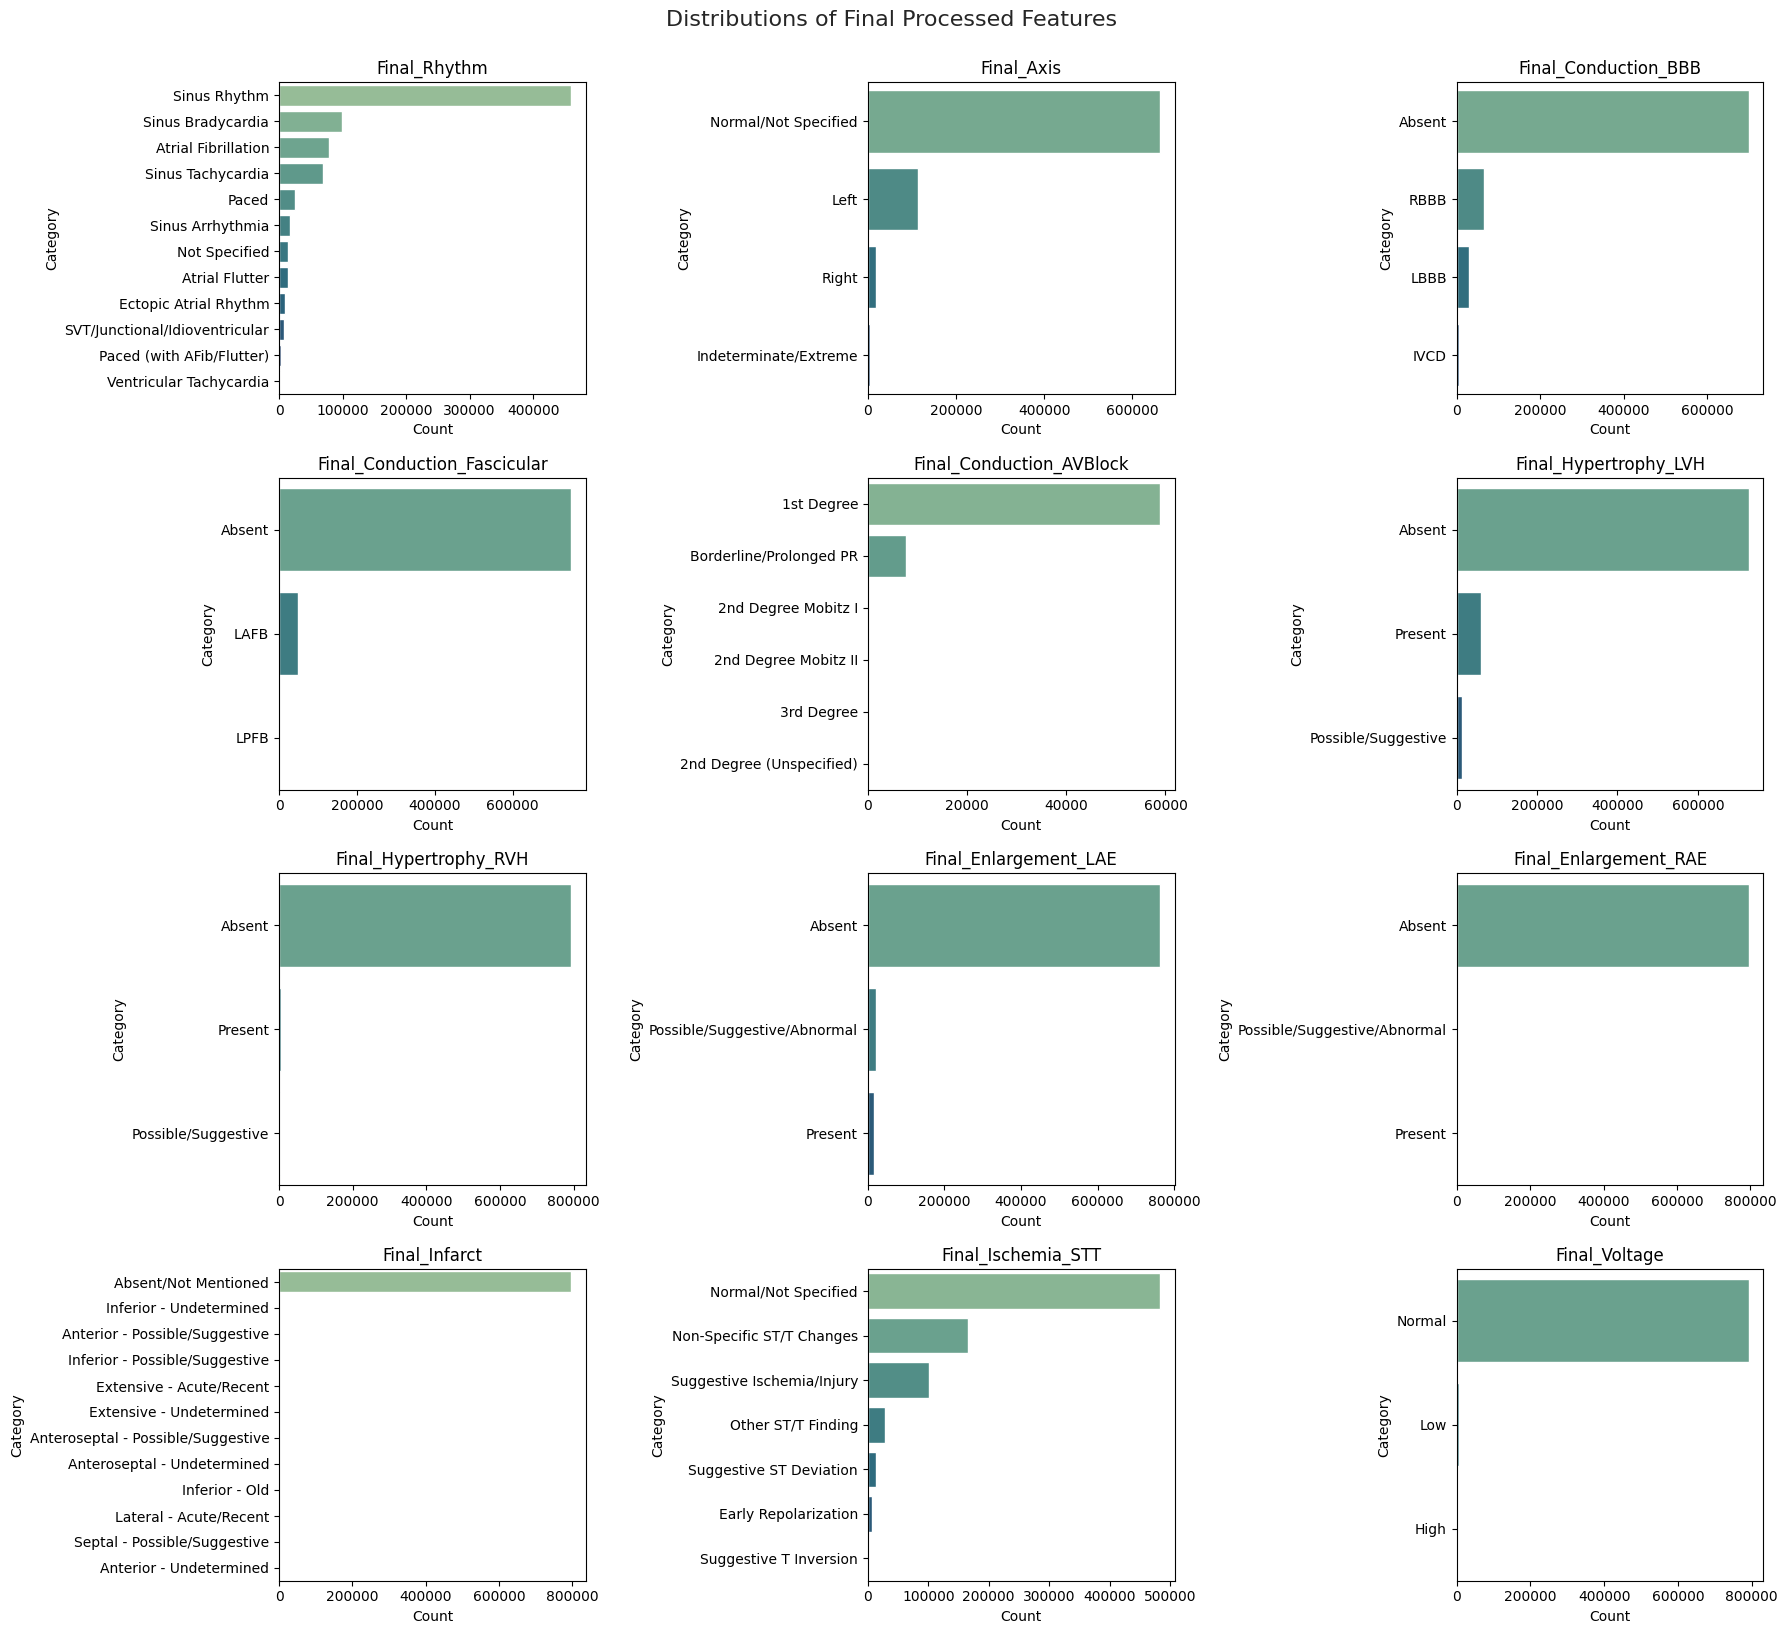

In [ ]:
measure_df = pd.read_csv("measure_df_with_final_features.csv")

# Identify 'Final_' columns
final_feature_columns = [col for col in measure_df.columns if col.startswith('Final_')]

num_cols = 3
num_rows = 4
max_categories_to_plot = 12
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 16))
axes = axes.flatten()

sns.set(style="whitegrid")

# Loop through each column and plot
for i, col_name in enumerate(final_feature_columns[:len(axes)]):  # limit to grid size
    ax = axes[i]
    counts = measure_df[col_name].value_counts(dropna=False).sort_values(ascending=False).head(max_categories_to_plot)

    sns.barplot(
        x=counts.values,
        y=counts.index,
        hue=counts.index,
        palette="crest",
        dodge=False,
        legend=False,
        ax=ax
    )
    ax.set_title(f"{col_name}", fontsize=12)
    ax.set_xlabel("Count")
    ax.set_ylabel("Category")

# Turn off any unused subplots
for j in range(len(final_feature_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distributions of Final Processed Features", fontsize=16, y=1.02)
plt.show()

We visualized the distribution of labels from the machine-interpreted ECG reports (e.g., Final_Rhythm, Final_Conduction_BBB, Final_Infarct, etc.). As expected, the vast majority of ECGs are labeled as normal or absent across most diagnostic dimensions. Labels such as “Sinus Rhythm,” “Normal,” and “Absent” dominate. Conversely, clinically significant abnormalities like ventricular tachycardia or infarction are rare. This pronounced class imbalance limits the utility of supervised classifiers trained directly on these labels.

In [ ]:
def contextualize_label(col, val):
    if pd.isna(val): return np.nan
    if val.lower() in {'absent', 'none', 'absent/not mentioned'}:
        return f'No {col.replace("Final_", "").replace("_", " ")}'
    elif val.lower() in {'normal', 'normal/not specified'}:
        return f'Normal {col.replace("Final_", "").replace("_", " ")}'
    else:
        return f'{col.replace("Final_", "").replace("_", " ")}: {val}'

In [ ]:
final_labels = measure_df[final_feature_columns].copy()
for col in final_labels.columns:
    final_labels[col] = final_labels[col].apply(lambda x: contextualize_label(col, x))

# Drop rows with no findings at all
final_labels = final_labels.dropna(how='all')

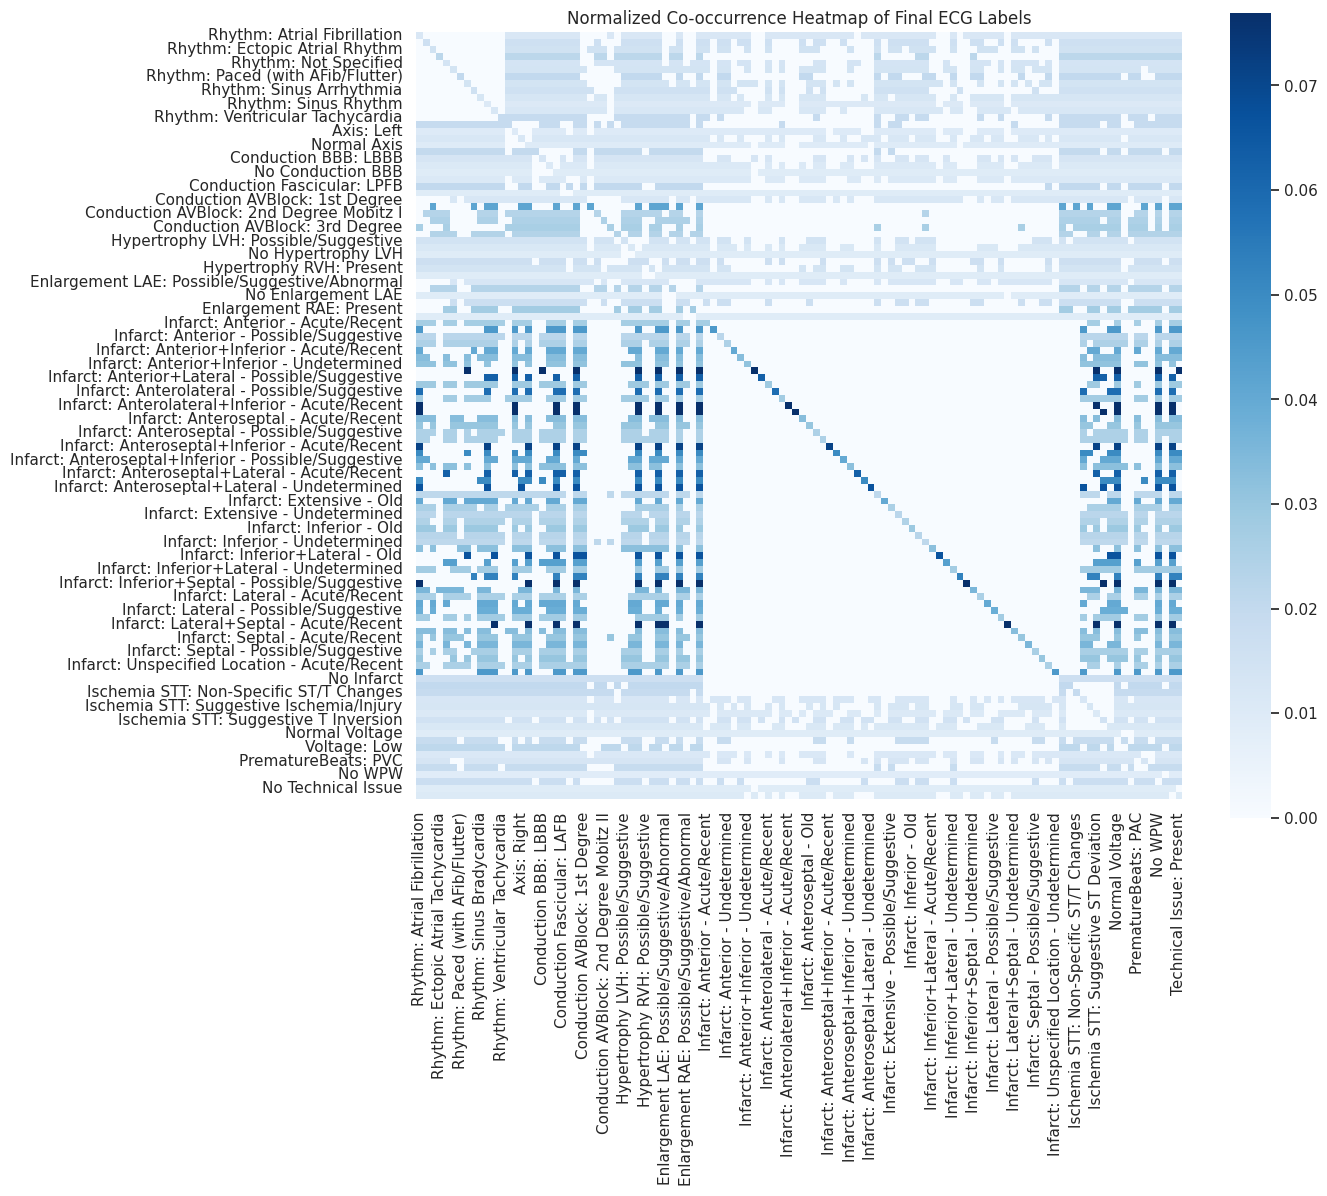

In [ ]:
from itertools import combinations
from collections import Counter
from sklearn.metrics import jaccard_score

binary_final_labels = pd.get_dummies(final_labels, prefix='', prefix_sep='')


co_occurrence = binary_final_labels.T.dot(binary_final_labels)
co_occurrence = co_occurrence.div(co_occurrence.sum(axis=1), axis=0) #normalize over row to look at co-occurrence values per label (i.e. how tangled or pure each label is)
plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence, cmap="Blues", square=True)
plt.title("Normalized Co-occurrence Heatmap of Final ECG Labels")
plt.tight_layout()
plt.show()

The row-normalized co-occurrence matrix illustrates the proportion of times each diagnostic label is observed in combination with others. Diagonal values vary in intensity, indicating that some labels appear mostly in isolation (e.g., “Normal Rhythm”), while others (e.g., infarct patterns or ischemic changes) frequently co-occur. This matrix confirms that certain ECG pathologies, such as multi-territory infarctions or combined conduction + rhythm disturbances, are clinically interrelated. However, this visualization also highlights that the majority of ECGs are not cleanly classifiable into a single label, reinforcing the need for flexible, anomaly-aware modeling like an autoencoder.

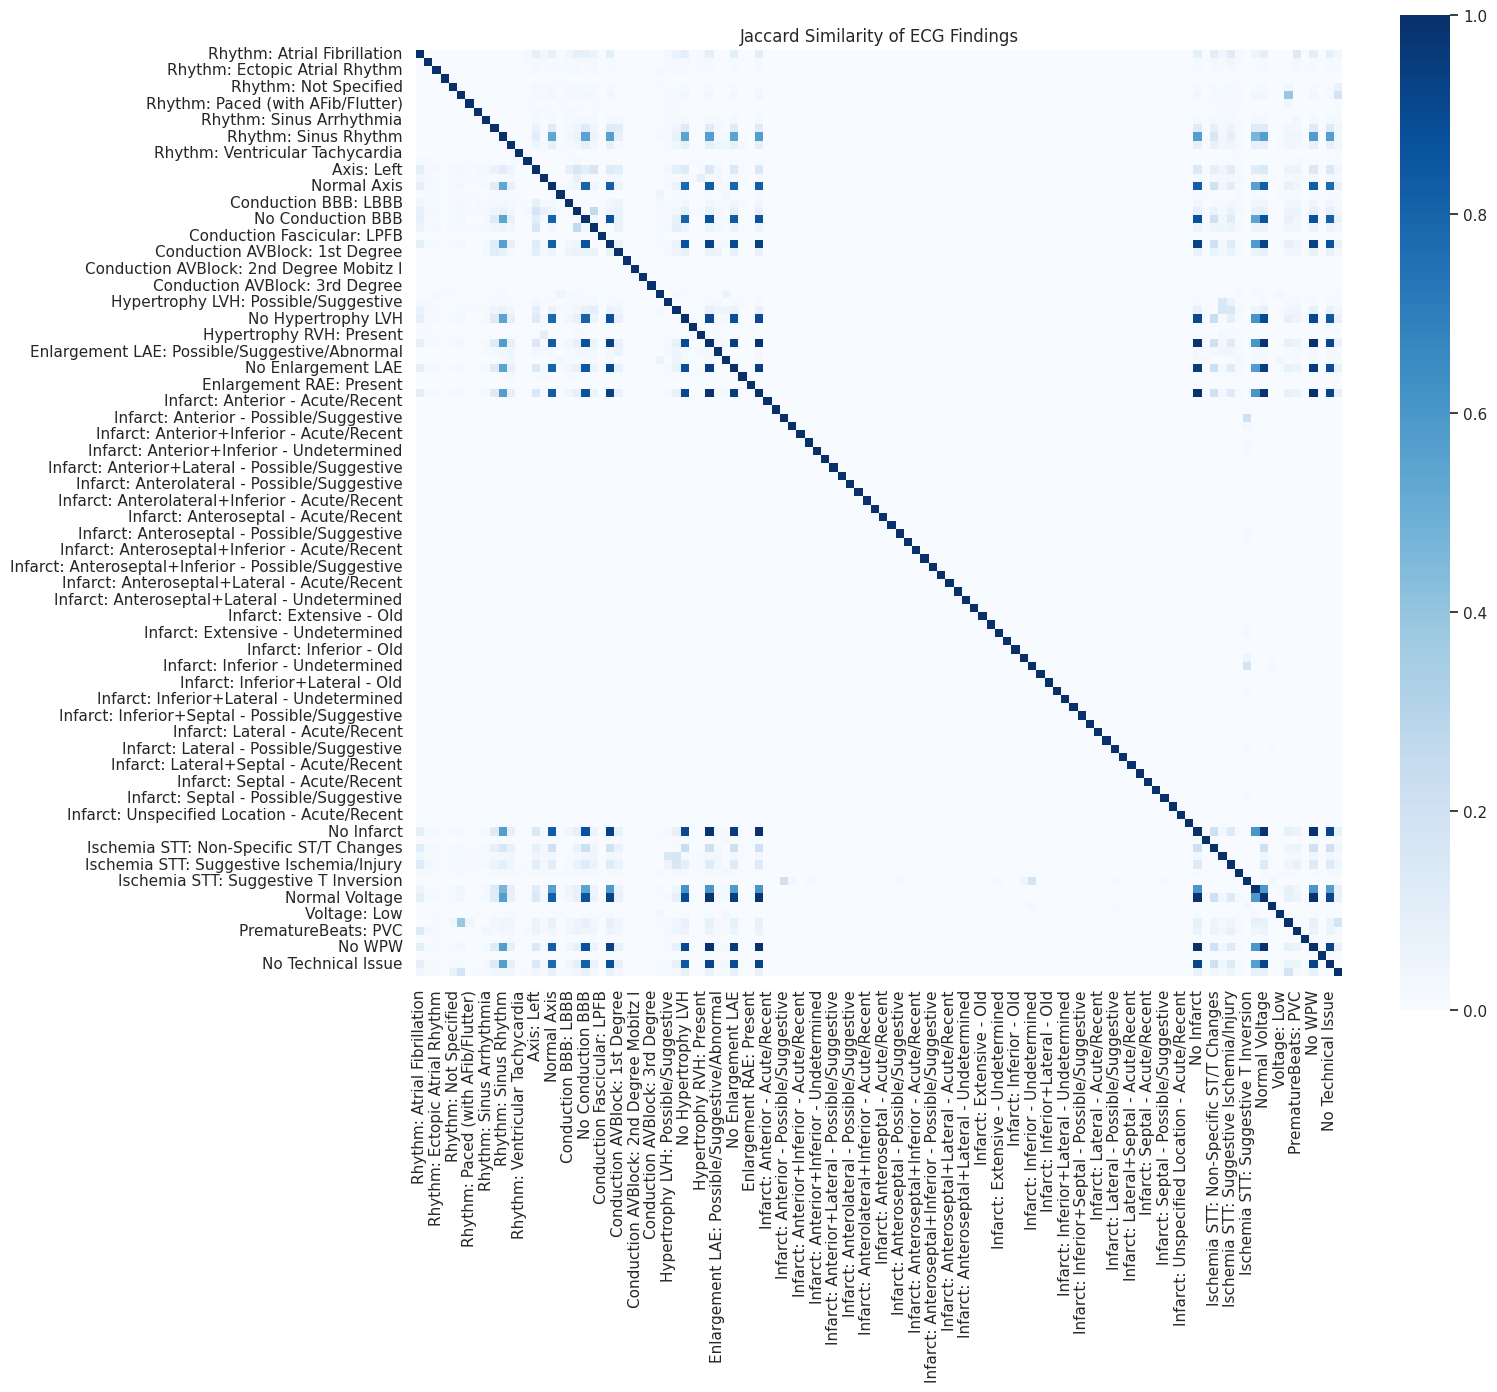

In [ ]:
from sklearn.metrics import pairwise_distances

bool_matrix = binary_final_labels.astype(bool).values
jaccard_sim = 1 - pairwise_distances(bool_matrix.T, metric='jaccard')

jaccard_df = pd.DataFrame(jaccard_sim, index=binary_final_labels.columns, columns=binary_final_labels.columns)

plt.figure(figsize=(16, 14))
sns.heatmap(jaccard_df, cmap="Blues", square=True)
plt.title("Jaccard Similarity of ECG Findings")
plt.tight_layout()
plt.show()

We also looked at the Jaccard similarity plot for a more interpretable measure of label co-occurrence strength. Unlike the row-normalized co-occurrence matrix, Jaccard similarity focuses on shared overlap, so we can see that there is strong co-occurrence among related infarct locations, and moderate similarity between ST/T changes and ischemic/injury labels. Based on this plot, we can see that there are some label groupings or clusters, which could be used for certain downstream tasks (e.g., grouping certain abnormalities/diagnoses together).